# **Gold Price Forecast**



The task is to forecast **gold spot price** on *Jul 24, 2020*. As a short summary, following **four models** are invested and fine-tuned:
- Autoregressive **(AR)** Model of order 0 to 50, in **Sec.3.2**
- Autoregressive Distributed Lag **(ADL)** Model of order 0 to 20, in **Sec.3.3**
- Autoregressive Distributed Lag **(ADL)** Model of order 15 with consideration of **structural break**, in **Sec.3.7**
- Seasonal Autoregressive Integrated Moving Average **(SARIMA)** Model, in **Sec.3.8**

Data analysis **techinques** are performed and several **functions** are implemented for following purpose:
- Cross correlation, in **Sec.3.1**
- Stationarity test using Augmented Dickey Fuller **(ADF)** Test, in **Sec.3.4**
- Time series decomposition, in **Sec.3.5**
- Structural break test using **Chow Test**, in **Sec.3.6**

Auxiliary **data** are supposed to be useful according to literatures, and are analysed carefully:
- Crude oil price
- Silver price
- S&P 500 index
- Gold future price
- Google search trend for "gold investing"




In [1]:
# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np
from math import sqrt
from math import ceil 
from numpy import log
from pandas import Series
from pandas.plotting import autocorrelation_plot

# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Statistical model
from scipy.stats import f, pearsonr
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.graphics.correlation import plot_corr
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import seaborn as sns
from datetime import datetime
import subprocess

# set plot size 
plt.rcParams['figure.figsize'] = [24,12] 

# **1. Data Extraction**




## **1.1 Load the gold price data**

In [2]:
G_price = pd.read_csv('Gold_Historical_Data.csv')
G_price.head()

,Date,Price,Open,High,Low,Change %
0,21-Jul-20,"1,838.70","1,818.15","1,841.62","1,815.93",1.24%
1,20-Jul-20,"1,816.09","1,809.58","1,820.73","1,805.60",0.34%
2,17-Jul-20,"1,809.90","1,797.30","1,812.03","1,795.11",0.71%
3,16-Jul-20,"1,797.05","1,811.90","1,813.74","1,795.02",-0.82%
4,15-Jul-20,"1,811.90","1,807.80","1,814.79","1,802.72",0.23%


It is noticed that the date is not continuous, *Jul 18* and *Jul 19* are missing, which are weekends. Those data are not avaible, but this is not the case for other table. Attention needs to be made to the date when calculating correlation between data froom different tables.

In [3]:
G_price.isnull().any()

Date        False
Price       False
Open        False
High        False
Low         False
Change %    False
dtype: bool

Appearently there is no missing data in **gold price**.


## **1.2 Load the auxiliary data**

 I have prepared auxiliary data including:
 - Crude oil price
 - Silver price
 - S&P 500 index
 - Gold future price
 - Google search trend for "gold investing"
 
All the data start from 2019-01-01

In [4]:
O_price= pd.read_csv('Crude_Oil_WTI_Historical_Data.csv')
S_price= pd.read_csv('Silver_Historical_Data.csv')
Stock_ind= pd.read_csv('S&P_500_Historical_Data.csv')
G_future_price= pd.read_csv('Gold_Futures_Historical_Data.csv')
G_trend= pd.read_csv('Google_Trend.csv')

# **2. Data Processing**




In [5]:
# define the function to clean data
def data_clean(historical_data):
    historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.strftime('%Y-%m-%d')
    # remove the "," in the "Price", "Open', 'High', and 'Low' column and change the "string" type to "float"
    # change the price values to float type
    for item in ['Price','Open','High','Low']:
        historical_data[item]=historical_data[item].astype(str).str.replace(',', '').astype(float)
    if 'Vol.' in historical_data.columns:
        historical_data['Vol.']=historical_data['Vol.'].replace({'K': '*1e3','M': '*1e6', '-': '1'}, regex=True).map(pd.eval)
        historical_data['Vol.'] = historical_data['Vol.'].replace(1.0,np.NaN)
    historical_data['Change %']=historical_data['Change %'].replace({'%': '*1e-2'}, regex=True).map(pd.eval)
    return historical_data

## **2.1 Clean gold price and auxiliary data**

In [6]:
G_price = data_clean(G_price)
O_price = data_clean(O_price)
S_price = data_clean(S_price)
Stock_ind = data_clean(Stock_ind)
G_future_price = data_clean(G_future_price)

In [7]:
# clean data for google trend data
G_trend["Date"] = pd.to_datetime(G_trend["Date"]).dt.strftime('%Y-%m-%d')


# **3. Data and Model Exploration**


## 3.1 Exploring gold spot price data

The gold spot price data have multiple columns. We mainly care about the first column *Price*.

Let us take a look at the historical of gold price the the daily change of the gold price.

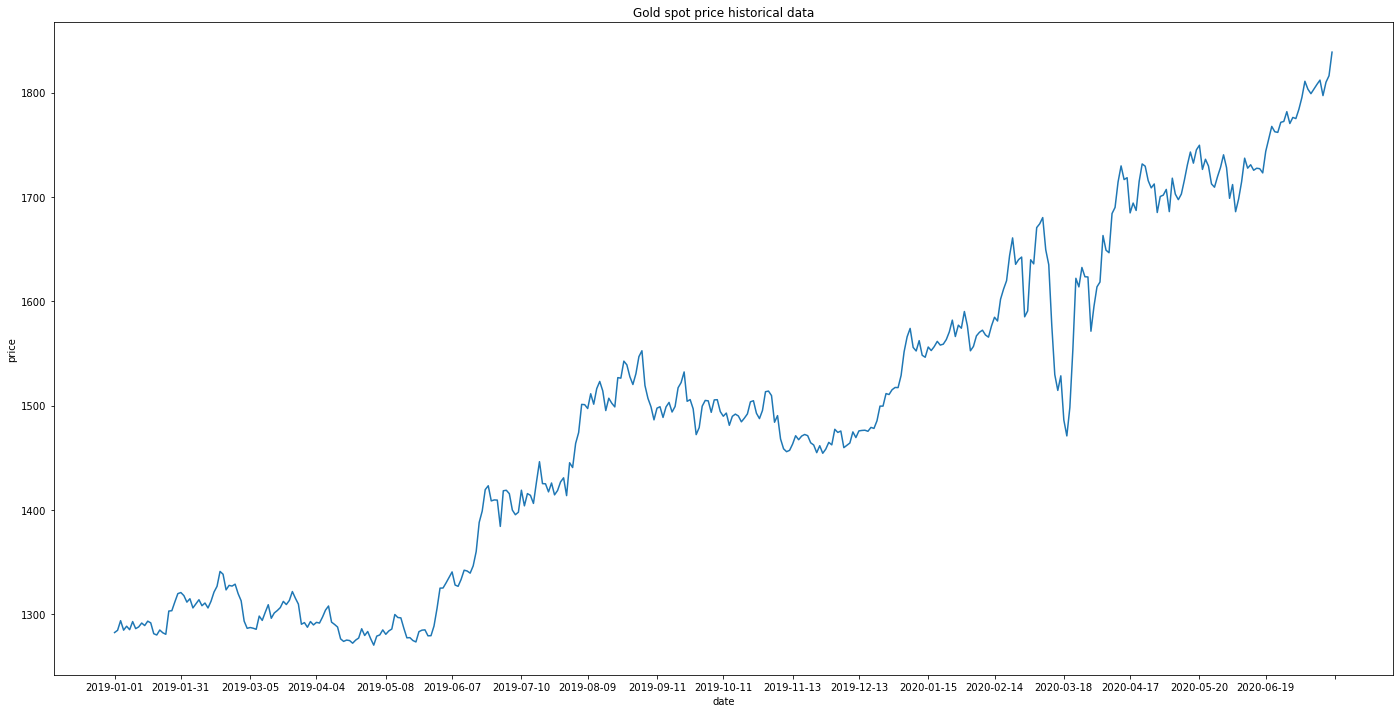

In [8]:
plt.figure()
plt.plot(np.flip(G_price['Date'].values),np.flip(G_price['Price'].values))
plt.xlabel('date')
plt.ylabel('price')
ax = plt.gca()
ax.set_xticks(np.linspace(0,len(G_price['Date']),19,endpoint=True,dtype='int64'))
plt.title('Gold spot price historical data')
plt.show()

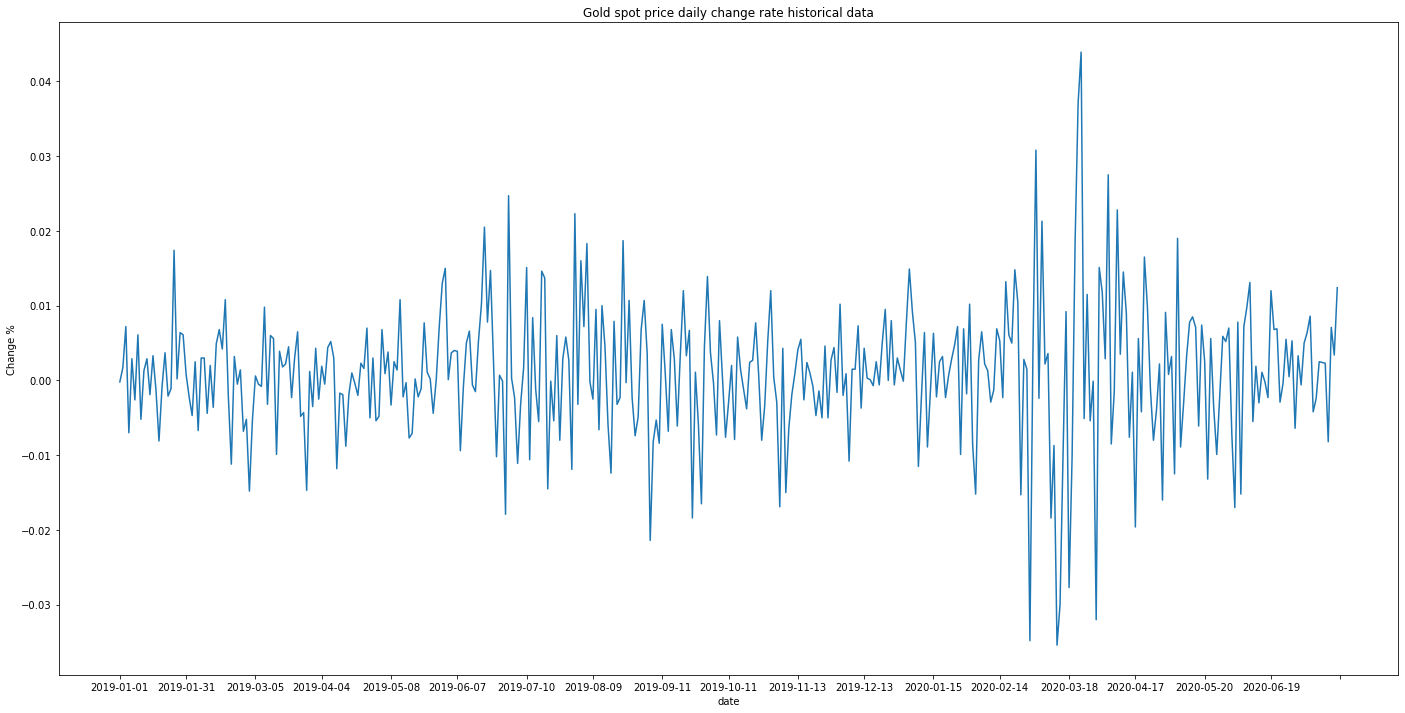

In [9]:
plt.figure()
plt.plot(np.flip(G_price['Date'].values),np.flip(G_price['Change %'].values))
plt.xlabel('date')
plt.ylabel('Change %')
ax = plt.gca()
ax.set_xticks(np.linspace(0,len(G_price['Date']),19,endpoint=True,dtype='int64'))
plt.title('Gold spot price daily change rate historical data')
plt.show()

Appearently there is an increasing trend of gold price through time. 

Economic time series sometimes show a stable percent change in the long run. Some conclusion from the change rate plot:
- there is little serial correlation in the daily percent change which makes this problem pretty hard
- high volatility for period between *2020-03* and *2020-04* 

In [10]:
G_price.describe()

,Price,Open,High,Low,Change %
count,405.000000,405.000000,405.000000,405.000000,405.000000
mean,1490.326346,1489.200444,1499.777160,1479.576099,0.000932
std,158.031824,157.544350,160.483856,154.754426,0.009009
min,1270.540000,1270.740000,1276.830000,1266.180000,-0.035400
25%,1323.490000,1321.800000,1328.340000,1317.390000,-0.003200
50%,1490.460000,1492.020000,1500.500000,1481.210000,0.001100
75%,1590.200000,1590.200000,1611.150000,1573.120000,0.005600
max,1838.700000,1818.150000,1841.620000,1815.930000,0.043900


It seem like all variables are well distributed. Let's darw histogram to check the distribution of each variable.

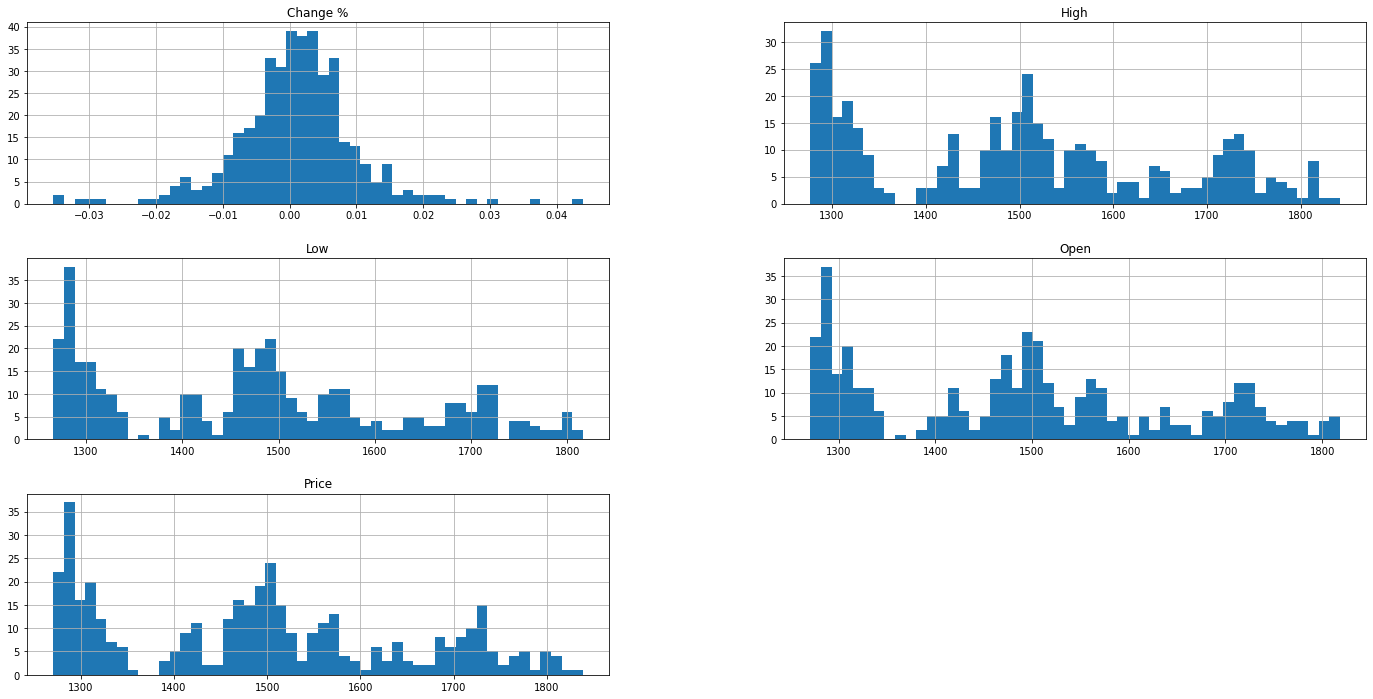

In [11]:
hist = G_price.hist(bins=50)



We can see *price, high, low, open* columns have similar distributions. Let's also plot the heatmap to show the correlations among different price columns.

Price       1.000000
Open        0.996082
High        0.997974
Low         0.998009
Change %    0.079491
Name: Price, dtype: float64


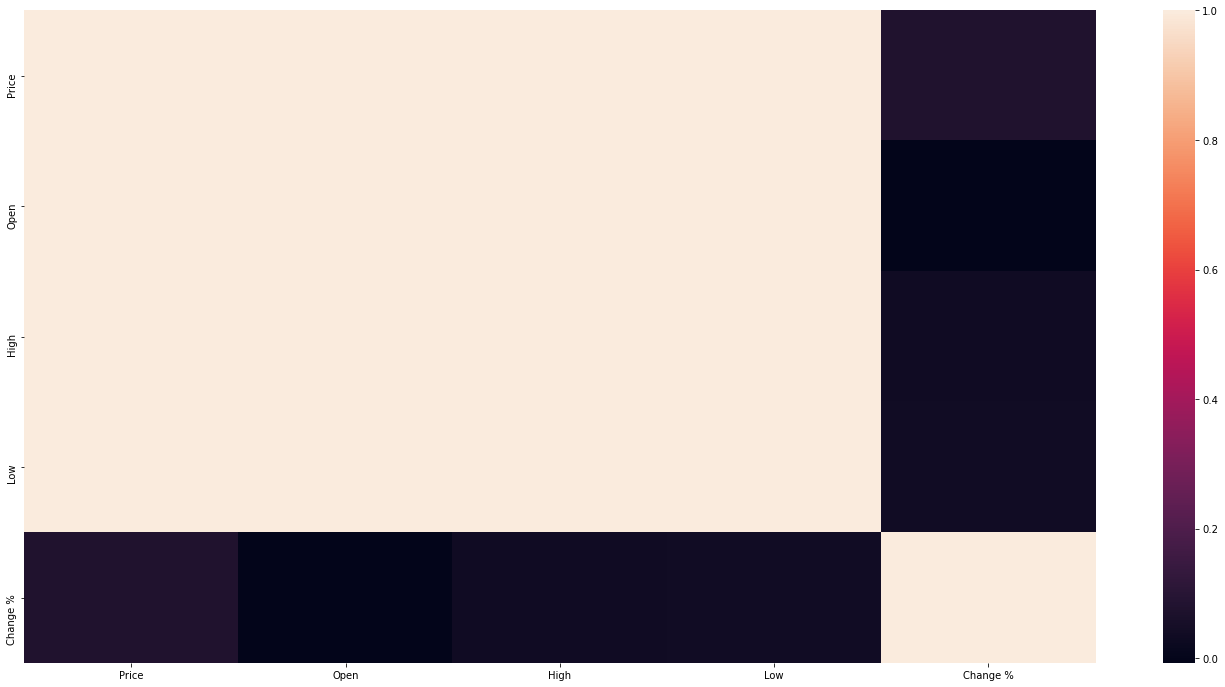

In [12]:
import seaborn as sns
corr = G_price.corr()
print(corr['Price'])
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

It is seen that the *price* is highly correlated with *High, Low* and *Open*. It is seen that the *price* is highly correlated with *High, Low* and *Open*.

Let run an autocorrelation function and partial autocorrelation function on the gold price data.

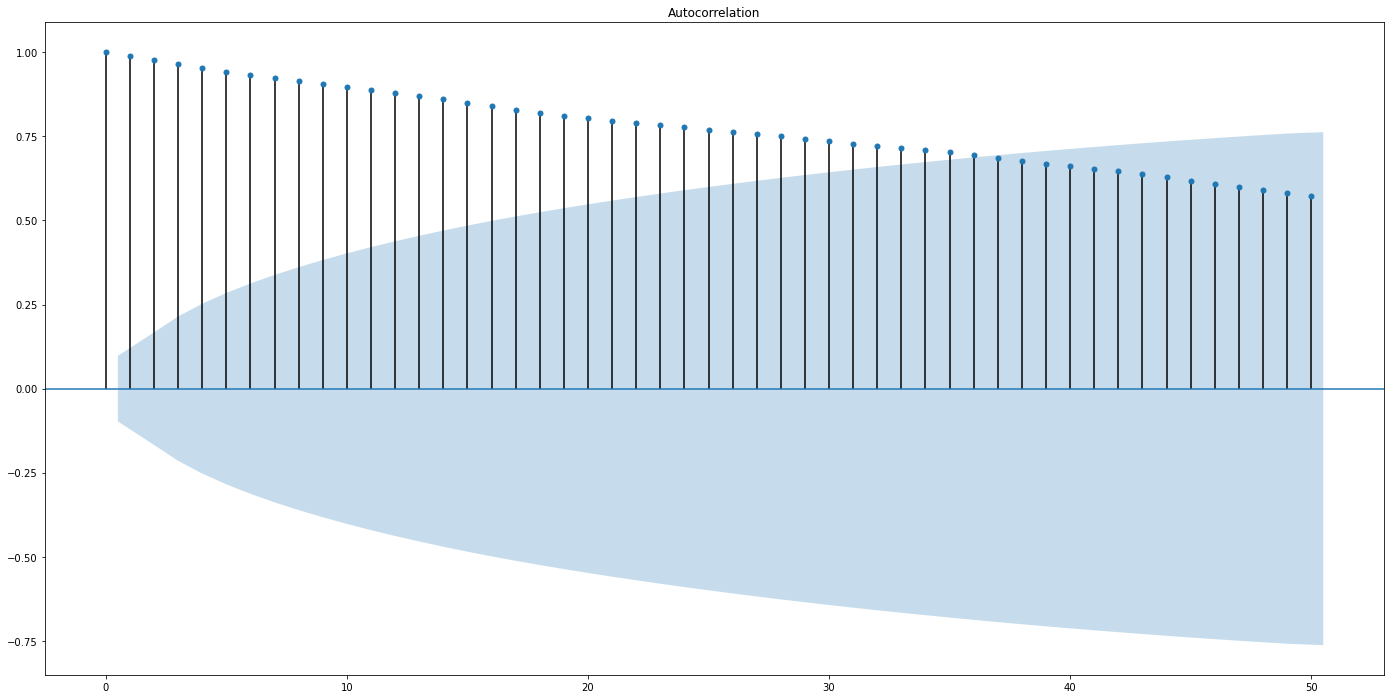

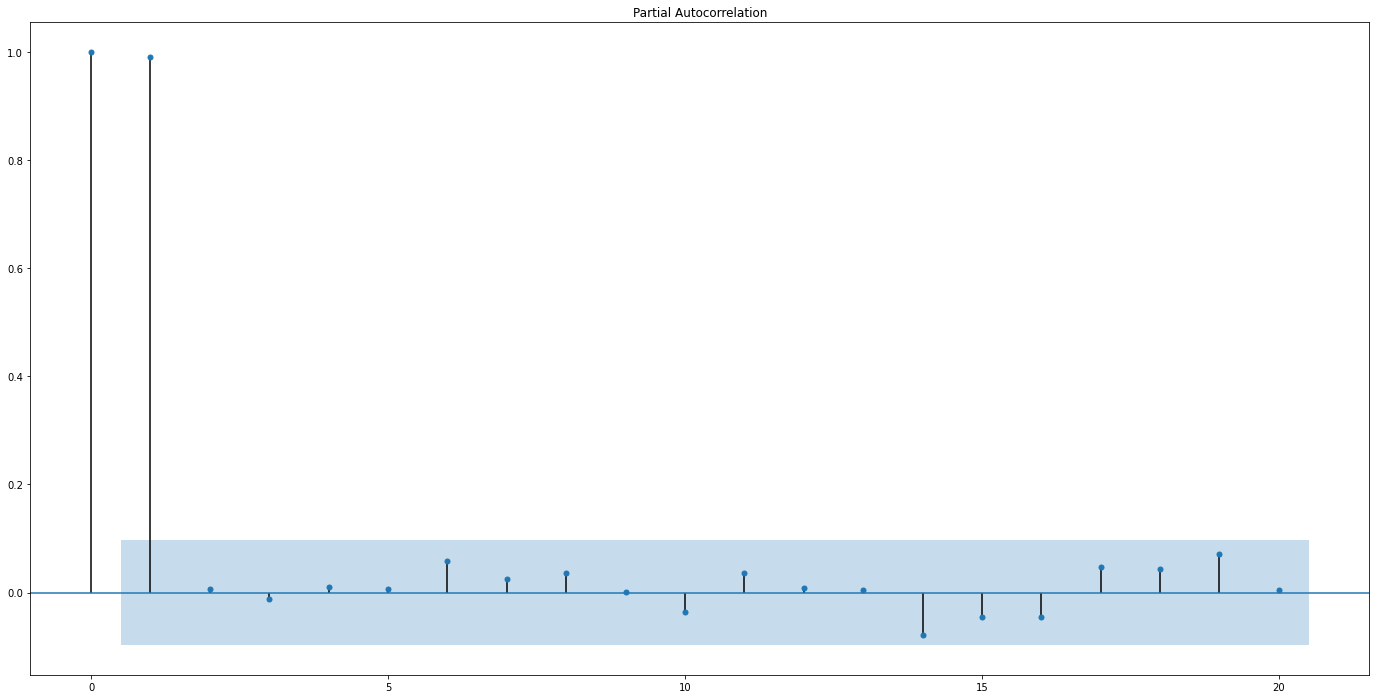

In [13]:
fig1 = plot_acf(G_price['Price'], lags=50)
fig2 = plot_pacf(G_price['Price'], lags=20)
plt.show()

Interestingly, we have the following findings:
- The autocorrelation shows that within 50 lagged days the price is highly correlated
- The partial autocorrelation shows that the high correlation value for *lag > 1* is mainly due to the indirect effect and the direct effect for *lag > 1* is actually very small.
- There are hidden patterns of **periodicity**, eg. at *lag=14* the direct correlation from has a local peak shown in the PACF plot

I'd like to take a look at the correlation between gold price and other collected data, trying to find some hints for predicting the gold price using other data.

## 3.2 Exploring auxiliary data

In [14]:
# define a function to calculate and plot the correlation between gold price and a given time series data with a given lag
def plot_lagged_corr(historical_data, total_lag, name):
    merge_GS=pd.merge(G_price, historical_data, on='Date')
    total_lag=total_lag
    corr=[]
    pvalue=[]
    tot_len=len(merge_GS)
    # calculate Pearson correlation coefficient and the p-value for the corresponding lag
    for nb_lag in range(total_lag):
        c, p = pearsonr(merge_GS['Price_x'].loc[nb_lag:], merge_GS['Price_y'].loc[:tot_len-nb_lag-1])
        corr.append(c)
        pvalue.append(p)
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(range(total_lag),corr,'bo-')
    plt.ylabel('corr')
    plt.title('Correlation between gold spot price and lagged '+name)
    plt.subplot(2,1,2)
    plt.plot(range(total_lag),pvalue,'g^-')
    plt.xlabel('lag')
    plt.ylabel('p-value')
    plt.title('Corresponding p-value')
    plt.show()

Checking four time series data including *silver price, crude oil price, S&P 500 index,* and *gold future price*

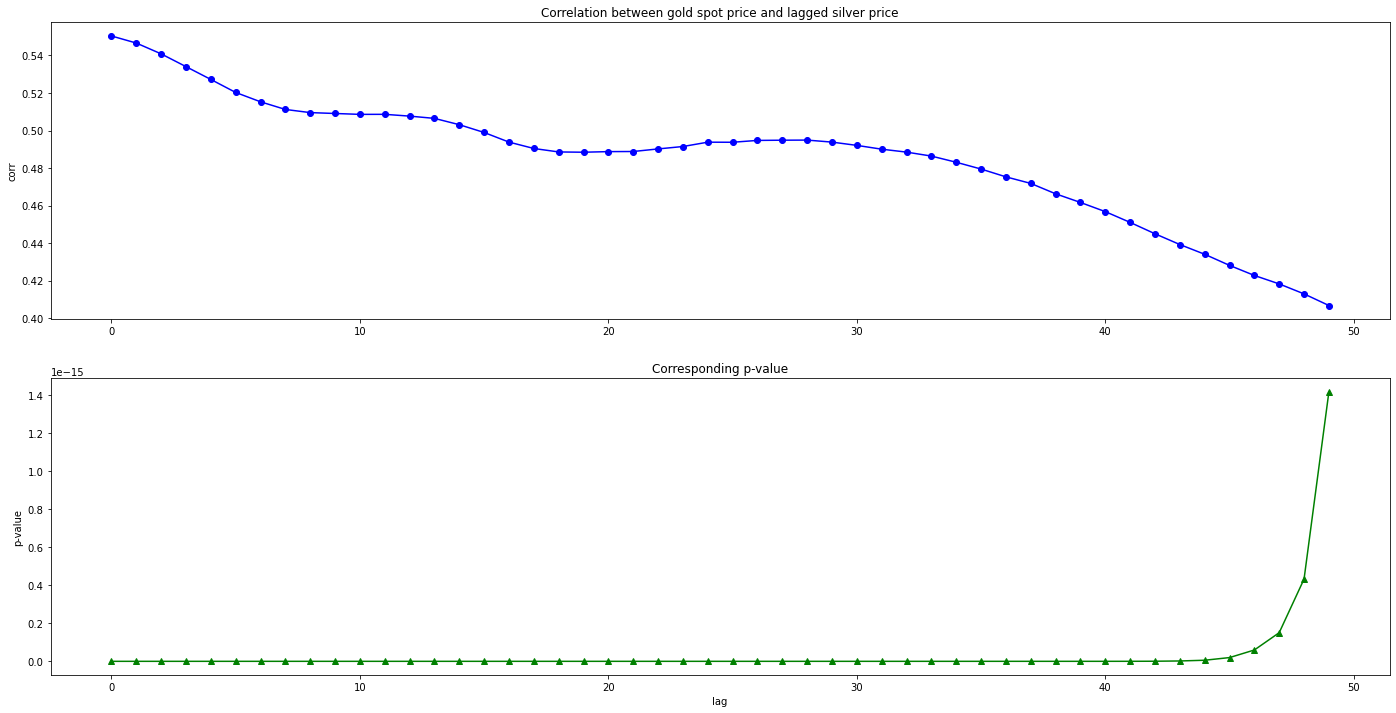

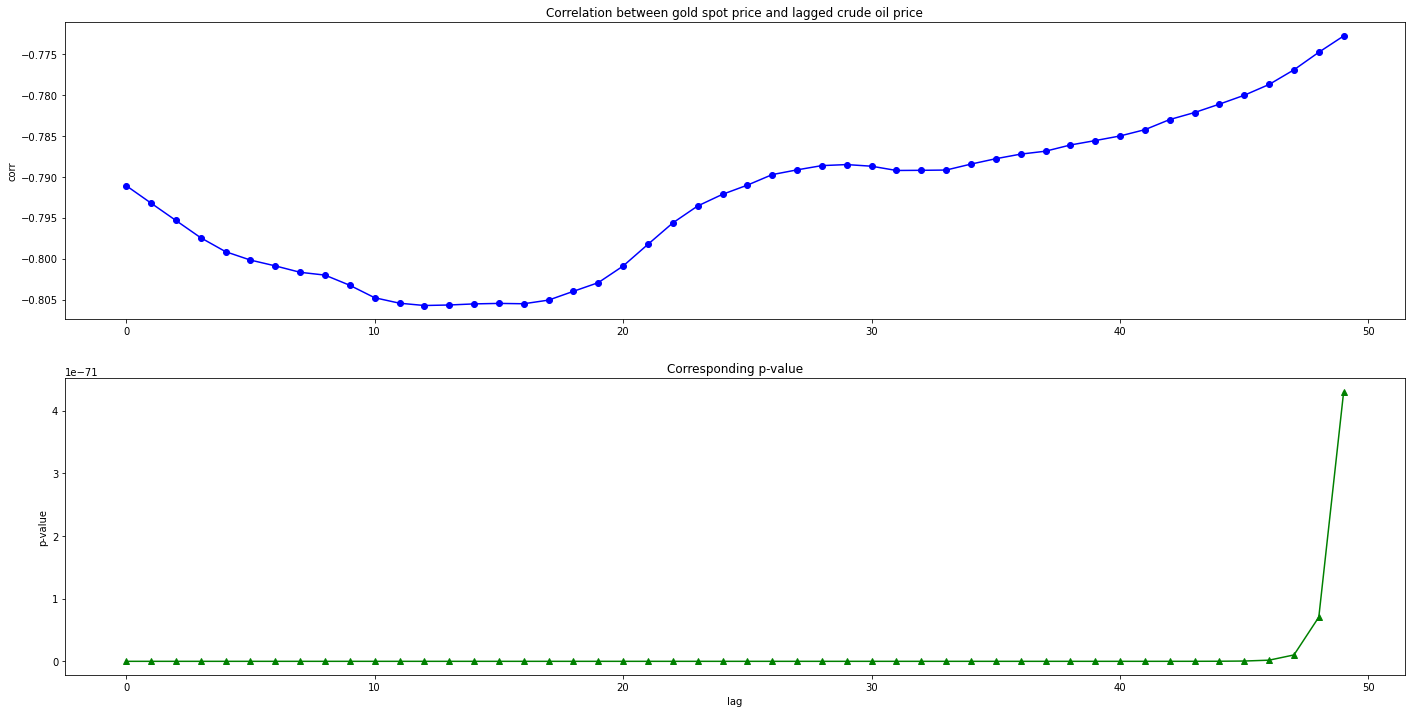

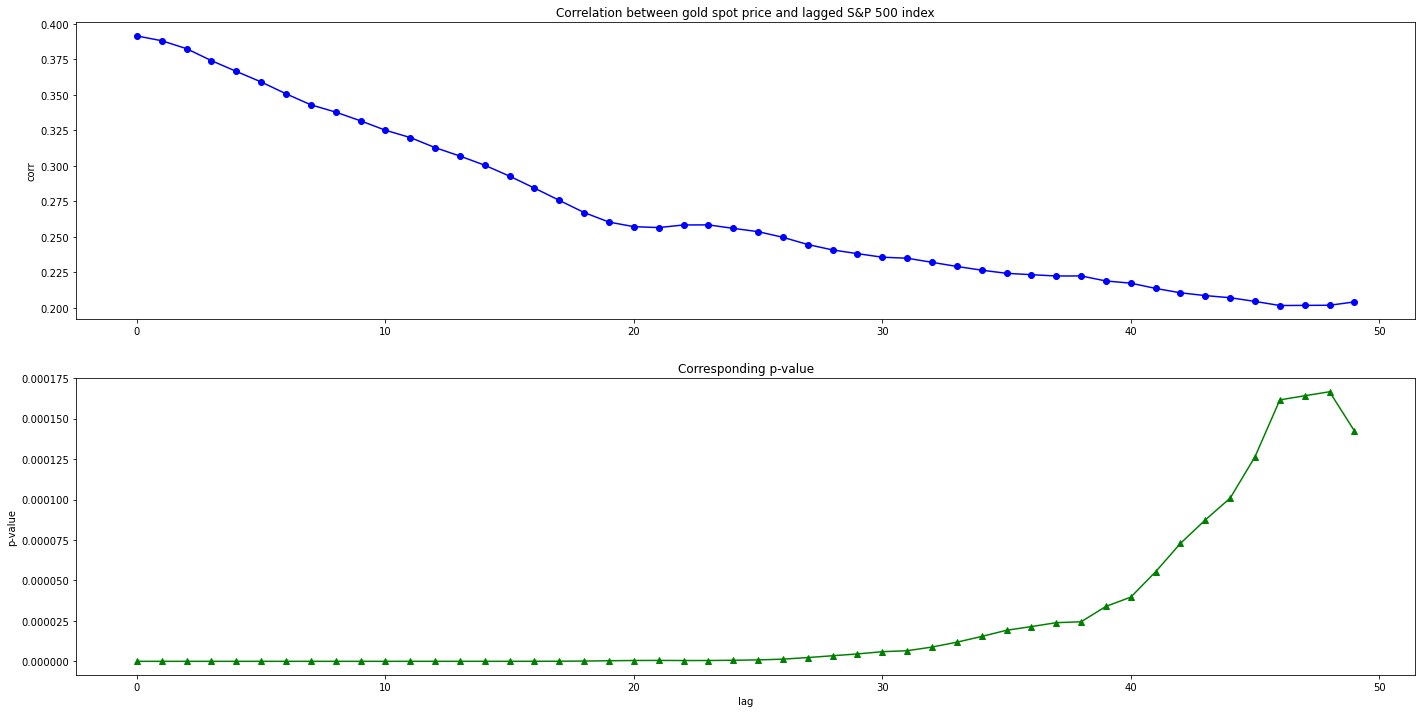

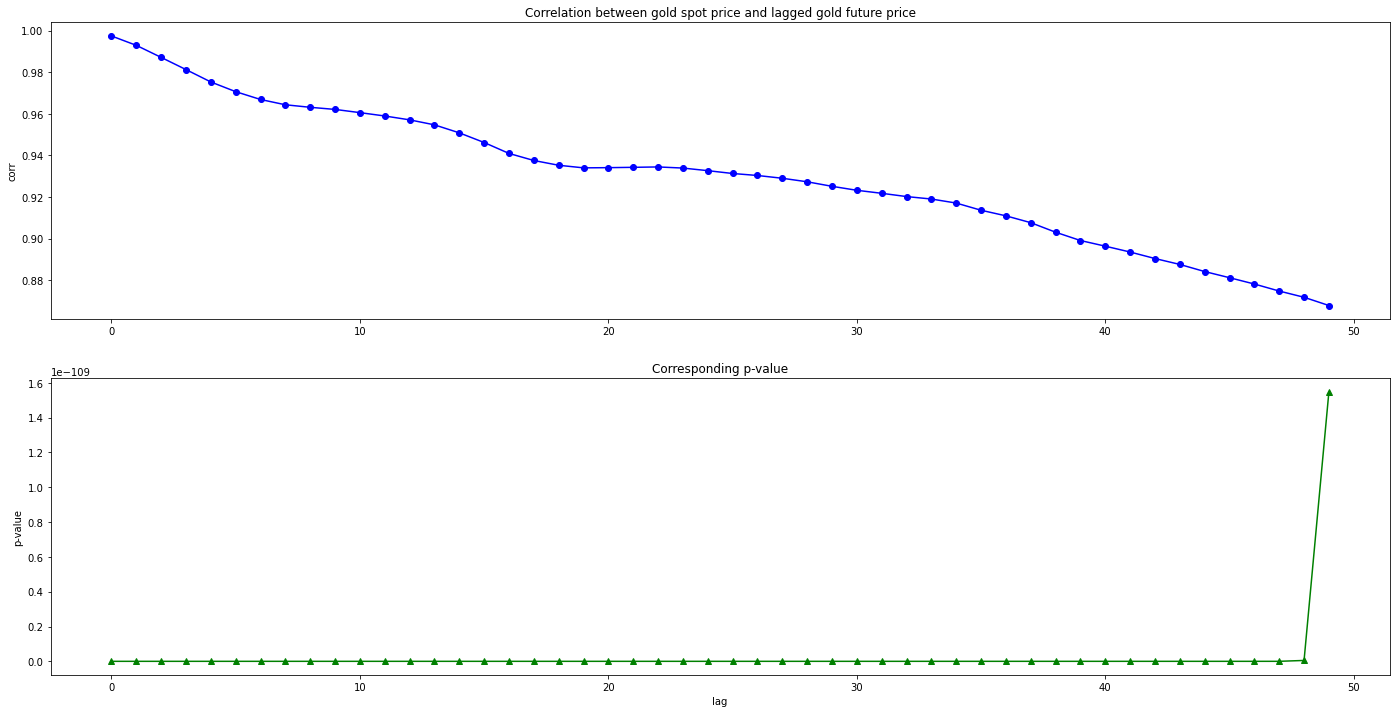

In [15]:
plot_lagged_corr(S_price, 50, 'silver price')
plot_lagged_corr(O_price, 50, 'crude oil price')
plot_lagged_corr(Stock_ind, 50, 'S&P 500 index')
plot_lagged_corr(G_future_price, 50, 'gold future price')



It seems *Gold spot price* and *Gold future price* have very strong correlation.

In [16]:
merge_sp500=pd.merge(G_price, G_future_price, on='Date')[['Price_x','Price_y']]
merge_sp500.columns=['G price','G future price']
merge_sp500.corr()

,G price,G future price
G price,1.000000,0.997442
G future price,0.997442,1.000000


It is confirmed that they are highly correlated and it might be sufficient to just use one of them.

Let's also look into the google search trend

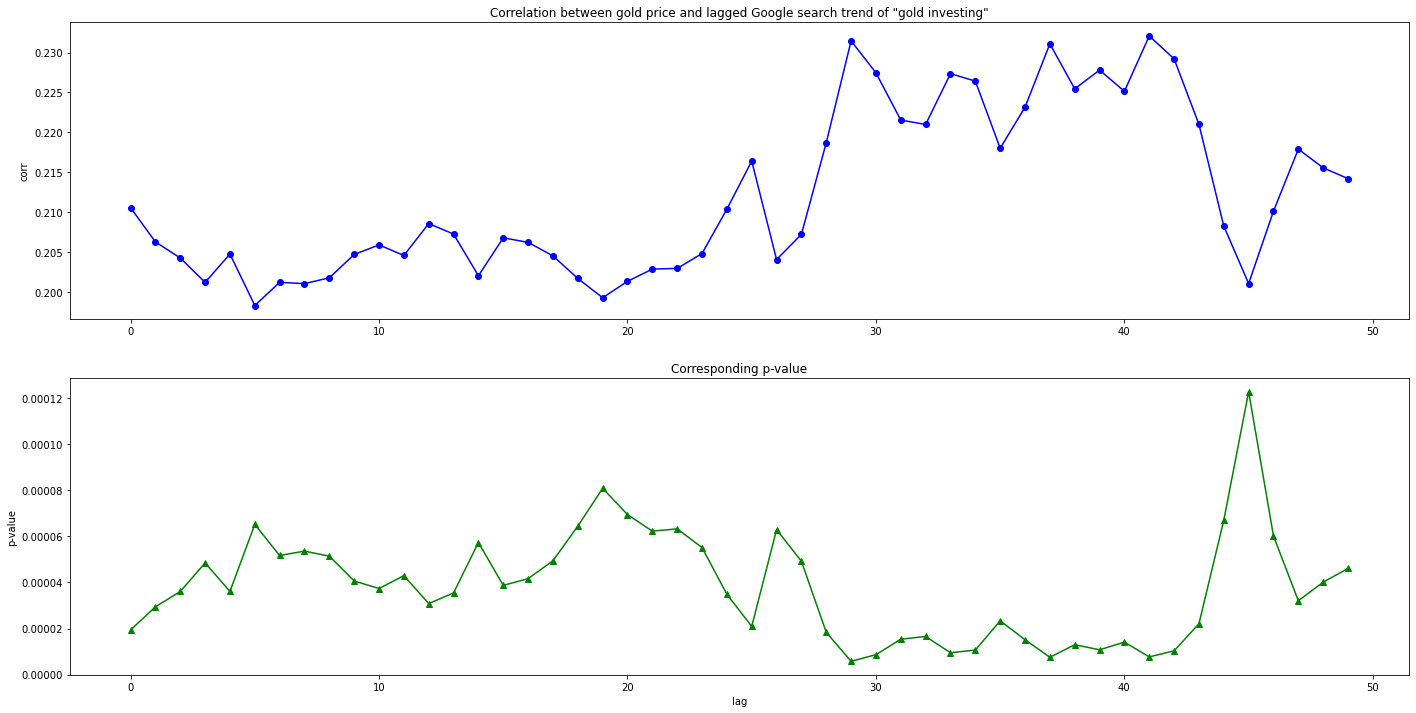

In [17]:
merge_gold_trend=pd.merge(G_price, G_trend, on='Date')
total_lag=50
corr=[]
pvalue=[]
tot_len=len(merge_gold_trend)
# calculate Pearson correlation coefficient and the p-value for the corresponding lag
for nb_lag in range(total_lag):
    c, p = pearsonr(merge_gold_trend['Price'].loc[nb_lag:], merge_gold_trend['Measure'].loc[:tot_len-nb_lag-1])
    corr.append(c)
    pvalue.append(p)
plt.figure()
plt.subplot(2,1,1)
plt.plot(range(total_lag),corr,'bo-')
plt.ylabel('corr')
plt.title('Correlation between gold price and lagged Google search trend of "gold investing"')
plt.subplot(2,1,2)
plt.plot(range(total_lag),pvalue,'g^-')
plt.xlabel('lag')
plt.ylabel('p-value')
plt.title('Corresponding p-value')
plt.show()

It is interesting that the Google search trend shows higher correlation that both Silver price and Stock price, over a higher number of lagged days with low *p-value*, the peak is shown at *lag = 10*. The data might be useful for the forecasting.

In [18]:
# Split the time series data into train and test
# 90% for training and 10% for testing
rate = 0.9
X = G_price.set_index('Date').sort_values('Date')['Price']
train, test = X[:int(rate*len(X))], X[int(rate*len(X)):]
print("Training set : % 3d, Testing set : % 2d" %(int(rate*len(X)), len(X)-int(rate*len(X))) )

Training set :  364, Testing set :  41


## 3.2 Autoregressive model

In [19]:
# define the rolling prediction function for AR model 
# to dynamically include new observation into known data and predict the next day value
def model_ar_prediction(model,train,test,lags,jump):
    coef = model.params
    history = list(train[len(train)-lags:])
    predictions = []
    nb_steps=len(test)//jump+1
    for t1 in range(nb_steps):
        # predict 3-day gold price
        for t2 in range(jump):
            if t1*jump+t2 >= len(test):
                return predictions
            length = len(history)
            lag_list = [history[i] for i in range(length-lags,length)]
            y_pred = coef[0]
            for d in range(lags):
                y_pred += coef[d+1] * lag_list[lags-d-1]
            predictions.append(y_pred)
            history.append(y_pred)
        # when arriving at the end of the 3rd day of the prediction period, includes the observed true price into training set 
        length = len(history)
        history[length-jump:] = test[jump*t1:jump*(t1+1)].values
    return predictions

In [20]:
# define our own autoregressive pipeline, which dynamically predict the gold price in the coming day. 
# New observation data is automatically employed for the prediction of next 3-day (jump=3 in the function) period price.
def ar_pipeline(train,test,lags,show_result,show_plot):
    model = AutoReg(train.values, lags=lags)
    model_ar_fit = model.fit()
    jump = 3
    predictions = model_ar_prediction(model_ar_fit,train,test,lags,jump)
    mse = mean_squared_error(test, predictions)
    aic = model_ar_fit.aic
    if show_result:
        print('Lag %d evaluation: Test MSE: %.3f; MODEL AIC: %.3f' % (lags,mse,aic))
    if show_plot:
        plt.plot(test,label='True')
        plt.plot(predictions, color='red', label='Predict')
        plt.title('Gold spot price prediction with AR model')
        ax = plt.gca()
        ax.set_xticks(np.linspace(0,len(test),19,endpoint=True,dtype='int64'))
        plt.legend()
        plt.show()
    return model_ar_fit, mse, aic

Best model is with  6, Test MSE: 318.237; MODEL AIC: 5.306


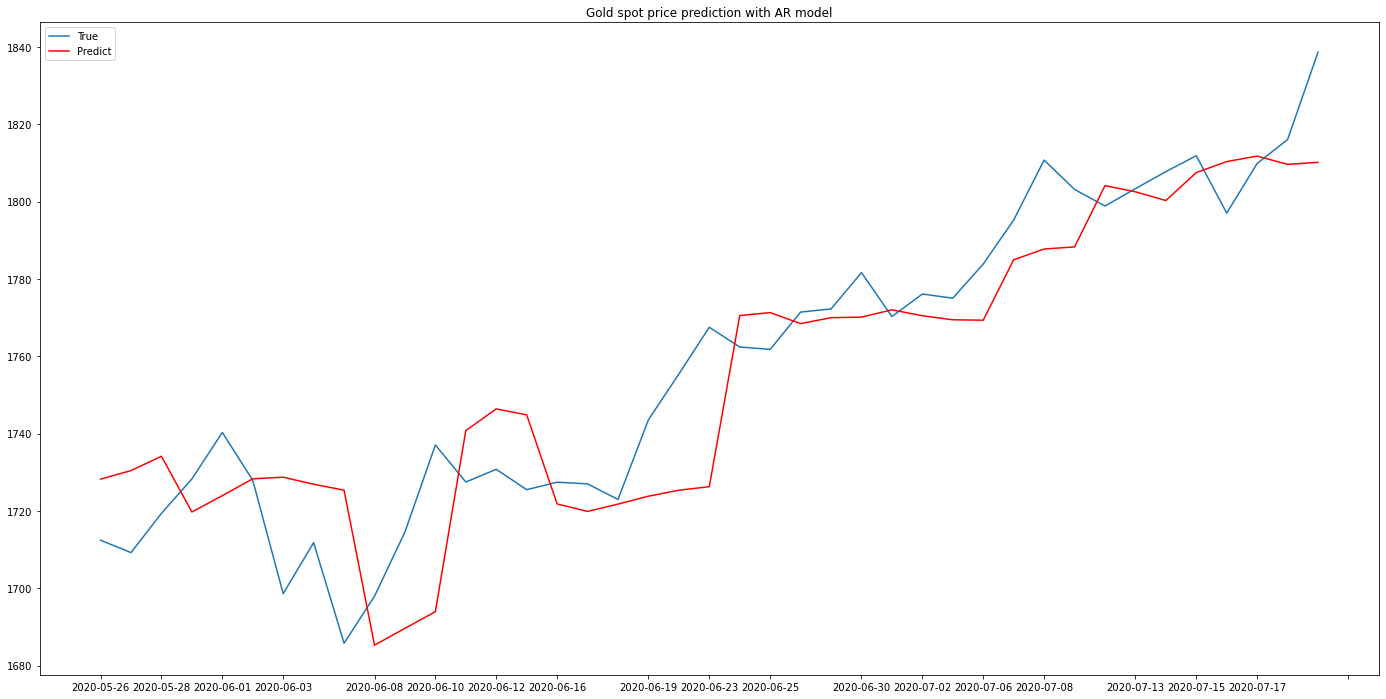

In [21]:
aics=[]
mses=[]
for nb_lag in range(50):
    model, mse, aic = ar_pipeline(train,test,nb_lag,show_result=False,show_plot=False)
    aics.append(aic)
    mses.append(mse)
print('Best model is with  %d, Test MSE: %.3f; MODEL AIC: %.3f' % (aics.index(min(aics)),mses[aics.index(min(aics))],min(aics)))
best_model, best_mse, best_aic = ar_pipeline(train,test,aics.index(min(aics)),show_result=False,show_plot=True)

In [22]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:                     AutoReg(6)   Log Likelihood               -1449.801
Method:               Conditional MLE   S.D. of innovations             13.885
Date:                Tue, 21 Jul 2020   AIC                              5.306
Time:                        14:29:15   BIC                              5.393
Sample:                             6   HQIC                             5.341
                                  364                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0947      8.103      0.382      0.703     -12.787      18.977
y.L1           1.0514      0.052     20.126      0.000       0.949       1.154
y.L2           0.0046      0.076      0.060      0.952      -0.145       0.154
y.L3          -0.0459      0.076     -0.601      0.548      -0.196       0.104
y.L4          -0.1025      0.076     -1.340      0.180      -0.252       0.047
y.L5          -0.0616      0.077     -0.804      0.421      -0.212       0.089
y.L6           0.1528      0.053      2.901      0.004       0.050       0.256
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0010           -0.0000j            1.0010           -0.0000
AR.2            1.0868           -0.7938j            1.3459           -0.1004
AR.3            1.0868           +0.7938j            1.3459            0.1004
AR.4           -0.5888           -1.3846j            1.5046           -0.3140
AR.5           -0.5888           +1.3846j            1.5046            0.3140
AR.6           -1.5938           -0.0000j            1.5938           -0.5000
-----------------------------------------------------------------------------
"""

Finding from the AR model:
- Generally speaking the forecasting result is OK and the model is able to catch the increasing trend as well as the price fluctuations. The Mean Square Error is also large with a value of *318.237*.
- It is shown that for smooth region, the prediction is good, but there is always a lagging effect, which especially hurt the prediction for abrupt change of the gold price.
- The coefficient for the first lag is nearly 1, with low p-value, while other coefficients are low, with high p-values, which shows similar information as the Partial Autocorrelation (PACF) plot does in **Sec.3.1**.

### Final Predicition for Gold Spot Price at *Jul 24* with AR model

In [23]:
final_test = pd.Series(index=['2020-07-22','2020-07-23','2020-07-24'],name='G_price')
final_train = G_price.set_index('Date').sort_values('Date')['Price']
lags = 6
jump = 3
model = AutoReg(final_train.values, lags=6)
model_ar_fit = model.fit()
predictions_ar = model_ar_prediction(model_ar_fit,final_train,final_test,lags,jump)

## 3.3 Autoregressive Distributed Lag (ADL) Models

The idea is to incorporate auxiliary data to build an ADL model. The model was implemented in several R packages, but not exist in any python package.

In [24]:
# define the function to return lagged variable
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n)
    else:
        x = pd.Series(x)
        return x.shift(n) 
    x = x.copy()
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

concatenate auxiliary data into one single dataframe

In [25]:
data=G_price[['Date','Price']]
for data_supp in [O_price,S_price,Stock_ind,G_future_price]:
    data=data.merge(data_supp[['Date','Price']],on='Date') 
data=data.merge(G_trend,on='Date')
data.columns=['Date','G_price','O_price','S_price','Stock_ind','G_f_price','G_trend']
data=data.sort_values('Date')
data.head()

,Date,G_price,O_price,S_price,Stock_ind,G_f_price,G_trend
390,2019-01-02,1284.77,45.66,15.517,2510.03,1332.8,64
389,2019-01-03,1293.99,46.78,15.736,2447.89,1343.6,53
388,2019-01-04,1284.92,48.18,15.694,2531.94,1334.8,91
387,2019-01-07,1288.67,48.66,15.646,2549.69,1339.0,26
386,2019-01-08,1285.35,49.89,15.655,2574.41,1334.9,69


These is not implemented package to run ADL model. The model is built using *statmodels* package and R-style formulas

In [26]:
aics=[]
# build an ADL model for each lag, and calculate AIC value, chose the model with the lowest AIC value
for max_lag in range(1,20):
    formula = 'G_price ~ 1 '
    for measure in ['G_price','S_price','O_price','Stock_ind','G_f_price','G_trend']:
        for n_lag in range(1,max_lag):
            formula = formula + '+ lag(' + measure +','+str(n_lag)+')'
    model_adl = smf.ols(formula = formula, data = data)
    model_adl_fit = model_adl.fit()
    aic=model_adl_fit.aic
    aics.append(aic)
    print('Lag %d, MODEL AIC: %.3f' % (max_lag,aic))
print('Lag %d gives the best AIC of %.3f' % (aics.index(min(aics)), min(aics)))

Lag 1, MODEL AIC: 5069.438
Lag 2, MODEL AIC: 3182.923
Lag 3, MODEL AIC: 3171.895
Lag 4, MODEL AIC: 3167.079
Lag 5, MODEL AIC: 3162.833
Lag 6, MODEL AIC: 3159.795
Lag 7, MODEL AIC: 3138.265
Lag 8, MODEL AIC: 3132.454
Lag 9, MODEL AIC: 3128.955
Lag 10, MODEL AIC: 3120.395
Lag 11, MODEL AIC: 3116.306
Lag 12, MODEL AIC: 3116.088
Lag 13, MODEL AIC: 3106.399
Lag 14, MODEL AIC: 3098.842
Lag 15, MODEL AIC: 3098.183
Lag 16, MODEL AIC: 3058.971
Lag 17, MODEL AIC: 3059.086
Lag 18, MODEL AIC: 3058.606
Lag 19, MODEL AIC: 3054.646
Lag 18 gives the best AIC of 3054.646


It seems that increasing the number of lags improves the AIC value. We are not expecting the model to be too complicated and wish to reduce the feature. Let's take a look at the model summary with all the tested features (*lag = 20* with all the auxiliary data).

In [27]:
model_adl_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                G_price   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     497.6
Date:                Tue, 21 Jul 2020   Prob (F-statistic):          6.20e-259
Time:                        14:29:35   Log-Likelihood:                -1418.3
No. Observations:                 373   AIC:                             3055.
Df Residuals:                     264   BIC:                             3482.
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             16.3303     54.915      0.297      0.766     -91.797     124.457
lag(G_price, 1)        0.5899      0.168      3.520      0.001       0.260       0.920
lag(G_price, 2)        0.1277      0.188      0.678      0.498      -0.243       0.498
lag(G_price, 3)        0.0686      0.192      0.358      0.721      -0.309       0.446
lag(G_price, 4)        0.1996      0.197      1.013      0.312      -0.189       0.588
lag(G_price, 5)        0.0850      0.192      0.442      0.659      -0.293       0.463
lag(G_price, 6)        0.0838      0.189      0.444      0.657      -0.288       0.455
lag(G_price, 7)       -0.2983      0.185     -1.617      0.107      -0.662       0.065
lag(G_price, 8)       -0.2454      0.185     -1.323      0.187      -0.610       0.120
lag(G_price, 9)       -0.3419      0.187     -1.831      0.068      -0.710       0.026
lag(G_price, 10)       0.0102      0.185      0.055      0.956      -0.354       0.375
lag(G_price, 11)       0.0490      0.184      0.267      0.790      -0.313       0.411
lag(G_price, 12)       0.1793      0.184      0.977      0.330      -0.182       0.541
lag(G_price, 13)       0.6590      0.182      3.621      0.000       0.301       1.017
lag(G_price, 14)       0.1789      0.188      0.954      0.341      -0.190       0.548
lag(G_price, 15)      -0.1797      0.189     -0.952      0.342      -0.551       0.192
lag(G_price, 16)      -0.0025      0.187     -0.013      0.989      -0.370       0.365
lag(G_price, 17)      -0.0775      0.177     -0.439      0.661      -0.426       0.271
lag(G_price, 18)      -0.0088      0.159     -0.055      0.956      -0.323       0.305
lag(S_price, 1)        5.2415      5.050      1.038      0.300      -4.702      15.185
lag(S_price, 2)       -2.0161      7.516     -0.268      0.789     -16.815      12.783
lag(S_price, 3)        0.2047      7.850      0.026      0.979     -15.252      15.662
lag(S_price, 4)      -10.2913      7.870     -1.308      0.192     -25.787       5.204
lag(S_price, 5)       -4.0475      7.719     -0.524      0.600     -19.246      11.151
lag(S_price, 6)        2.8467      7.495      0.380      0.704     -11.911      17.604
lag(S_price, 7)        1.3182      7.317      0.180      0.857     -13.088      15.725
lag(S_price, 8)        0.2452      7.227      0.034      0.973     -13.984      14.474
lag(S_price, 9)       14.8888      7.254      2.052      0.041       0.605      29.172
lag(S_price, 10)      -6.6751      7.284     -0.916      0.360     -21.018       7.668
lag(S_price, 11)       1.8332      7.309      0.251      0.802     -12.557      16.224
lag(S_price, 12)      -1.0019      7.337     -0.137      0.891     -15.449      13.445
lag(S_price, 13)      -9.7423      7.446     -1.308      0.192     -24.403       4.919
lag(S_price, 14)       5.3593      7.4

Since the p-value corresponding to most of the explanatory variables are greater than 0.05, we cannot reject the null hypothesis that the coefficient at the 5% level of significance. Accordingly, we drop this variable from the model and re-estimate the model with chosen variables.

In [28]:
# choose features with p_value < 0.05
coef_p_val=pd.DataFrame(model_adl_fit.pvalues.sort_values()[:20])
coef_p_val.columns=['p_value']
coef_p_val[coef_p_val['p_value']<0.05]

,p_value
"lag(Stock_ind, 15)",0.000041
"lag(G_price, 13)",0.000352
"lag(G_price, 1)",0.000508
"lag(Stock_ind, 14)",0.005359
"lag(G_trend, 2)",0.034966
"lag(S_price, 9)",0.041115
"lag(G_f_price, 13)",0.045375
"lag(G_f_price, 8)",0.046118


In [29]:
# build an ADL model with selected features, the maximum lag seems to be 15 because of the term lag(Stock_ind, 15)
# we manually define max_lag_adl_model = 16 = maximum lag +1
formula = 'G_price ~ 1 + lag(Stock_ind, 15) + lag(G_price, 13) + lag(G_price, 1) + lag(Stock_ind, 14) + lag(G_trend, 2) + lag(S_price, 9) + lag(G_f_price, 13) + lag(G_f_price, 8)'
model_adl = smf.ols(formula = formula, data = data)
model_adl_fit = model_adl.fit()
aic=model_adl_fit.aic
print('Chosen ADL MODEL AIC: %.3f' % aic)
print(model_adl_fit.summary())
max_lag_adl_model=16

Chosen ADL MODEL AIC: 3057.025
                            OLS Regression Results                            
Dep. Variable:                G_price   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     5809.
Date:                Tue, 21 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:29:45   Log-Likelihood:                -1519.5
No. Observations:                 376   AIC:                             3057.
Df Residuals:                     367   BIC:                             3092.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Inter

In [30]:
# define the prediction function for ADL model to perform 3-day period rolling prediction
def model_adl_prediction(model,train,test,lags,jump):
    coef = model.params
    history = train.iloc[len(train)-lags:]
    predictions = []
    nb_steps=len(test)//jump+1
    for t1 in range(nb_steps):
        # predict 3-day gold price
        for t2 in range(jump):
            if t1*jump+t2 >= len(test):
                return predictions
            length = len(history)
            lag_list = history.iloc[length-lags:]
            y_pred = model.predict(lag_list).values[lags-1]
            predictions.append(y_pred)
            history=history.append(history.iloc[length-1])
            history['G_price'].iloc[length]=y_pred
        # when arriving at the end of the 3rd day of the prediction period, includes the observed true price into training set
        length = len(history)
        history.iloc[length-jump:]=test.iloc[jump*t1:jump*(t1+1)].values
    return predictions

In [31]:
# Split the time series data into train and test
# 90% for training and 10% for testing
rate = 0.9
train, test = data.iloc[:int(rate*len(data))], data.iloc[int(rate*len(data)):]
print("Training set : % 3d, Testing set : % 2d" %(int(rate*len(data)), len(data)-int(rate*len(data))) )

Training set :  351, Testing set :  40


Lag 16 evaluation: Test MSE: 377.420


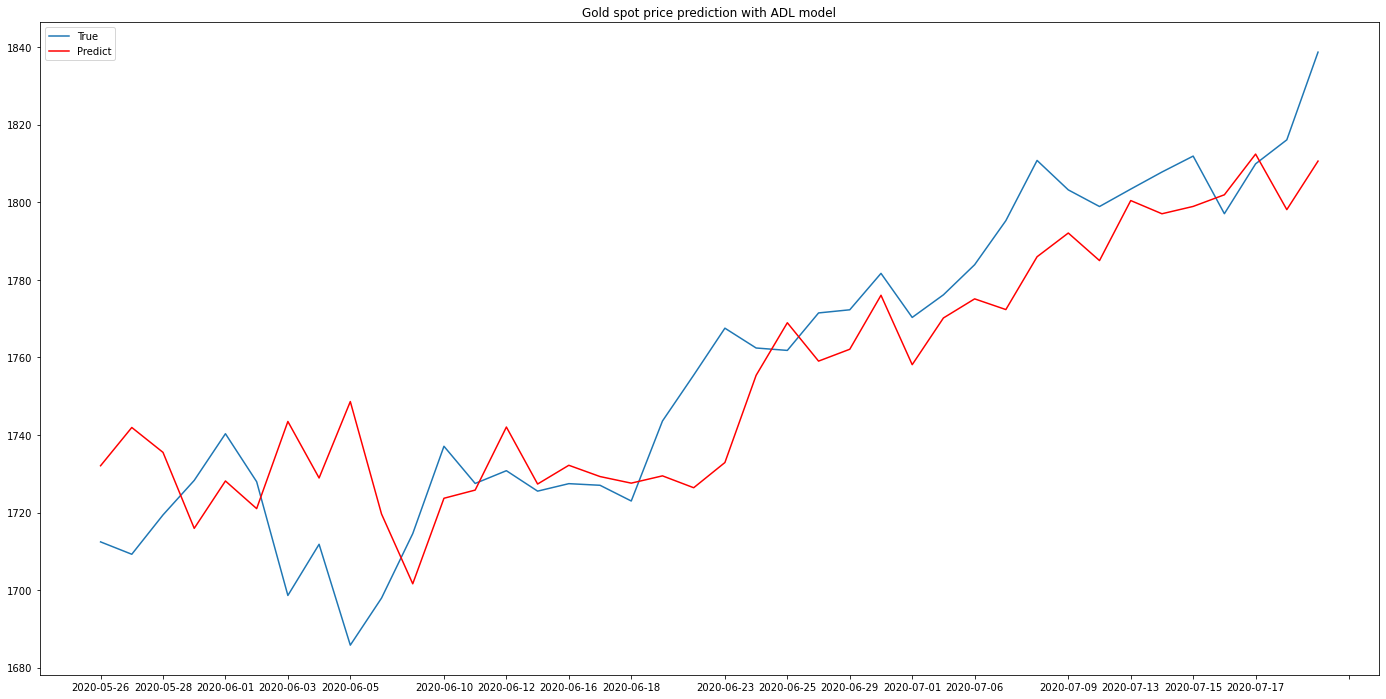

In [32]:
# Make a prediction of next 3-day (jump=3 in the function) period price with ADL mode.
jump=3
predictions = model_adl_prediction(model_adl_fit,train,test,max_lag_adl_model,jump)
mse = mean_squared_error(test['G_price'].values, predictions)
aic = model_adl_fit.aic
print('Lag %d evaluation: Test MSE: %.3f' % (max_lag_adl_model,mse))
plt.plot(test.set_index('Date')['G_price'] ,label='True')
plt.plot(predictions, color='red', label='Predict')
plt.title('Gold spot price prediction with ADL model')
ax=plt.gca()
ax.set_xticks(np.linspace(0,len(test),19,endpoint=True,dtype='int64'))
plt.legend()
plt.show()

In [33]:
model_adl_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                G_price   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     5809.
Date:                Tue, 21 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:30:01   Log-Likelihood:                -1519.5
No. Observations:                 376   AIC:                             3057.
Df Residuals:                     367   BIC:                             3092.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             64.7969     20.171      3.212      0.001      25.131     104.462
lag(Stock_ind, 15)    -0.0684      0.015     -4.556      0.000      -0.098      -0.039
lag(G_price, 13)       0.3489      0.089      3.915      0.000       0.174       0.524
lag(G_price, 1)        0.9414      0.021     44.382      0.000       0.900       0.983
lag(Stock_ind, 14)     0.0554      0.015      3.615      0.000       0.025       0.085
lag(G_trend, 2)       -0.0297      0.033     -0.895      0.371      -0.095       0.036
lag(S_price, 9)        0.3300      0.888      0.372      0.710      -1.416       2.076
lag(G_f_price, 13)    -0.3270      0.087     -3.742      0.000      -0.499      -0.155
lag(G_f_price, 8)      0.0227      0.025      0.892      0.373      -0.027       0.073
==============================================================================
Omnibus:                       26.338   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.298
Skew:                          -0.068   Prob(JB):                     2.02e-21
Kurtosis:                       5.463   Cond. No.                     1.44e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Finding from the ADL model:
- Different from the AR model which predicts a lagged "direct copy" of the input time series, the ADL model smoothes the time series, which means the model reduces the prediction variance.
- Generally it still show the lagging effect, especially for abrupt change of the gold price. The Mean Square Error is 377.420.
- There is an under-estimation of the gold price starting from *2020-06-18*
- The period from *2020-06-01* to *2020-06-10* is not well predicted.

### Final Predicition for Gold Spot Price at *Jul 24* with ADL model

In [34]:
final_test = pd.DataFrame(columns=['Date','G_price','O_price','S_price','Stock_ind','G_f_price','G_trend'])
final_test['Date'] = ['2020-07-22','2020-07-23','2020-07-24']
final_train = data
max_lag_adl_model=16
jump = 3
predictions_adl = model_adl_prediction(model_adl_fit,final_train,final_test,max_lag_adl_model,jump)

## 3.4 Stationarity Test with Augmented Dickey Fuller (ADF) Test

The concept of using the above autoregressive model is based on an assumption that the regressor is stationary. If that is not the case, the forecasting will be unreliable. In this section we are going to examin the nonstationarity of the time series.

The stationary test is performed with Augmented Dickey Fuller (ADF) test

In [35]:
# define function to test stationarity using Augmented Dickey Fuller (ADF) test
def stationarity_test(timeseries,dates):
    
    #Plot rolling statistics:
    roll_mean = timeseries.rolling(window=5).mean() 
    roll_std = timeseries.rolling(window=5).std()
    plt.figure()
    plt.subplot(2,1,1)
    orig = plt.plot(dates,timeseries, color='blue',label='Original')
    mean = plt.plot(dates,roll_mean, color='red', label='Rolling Mean')
    ax = plt.gca()
    ax.set_xticks(np.linspace(0,len(dates),19,endpoint=True,dtype='int64'))
    plt.ylabel('Price')
    plt.title('Rolling mean')
    plt.legend()
    plt.subplot(2,1,2)
    std = plt.plot(dates,roll_std, color='black', label = 'Rolling Std')
    plt.xlabel('Date')
    plt.ylabel('Std')
    plt.title('Rolling standard deriation')
    ax = plt.gca()
    ax.set_xticks(np.linspace(0,len(dates),19,endpoint=True,dtype='int64'))
    plt.legend()
    plt.show()
    
    #Perform ADF test:
    print ('Results of ADF Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

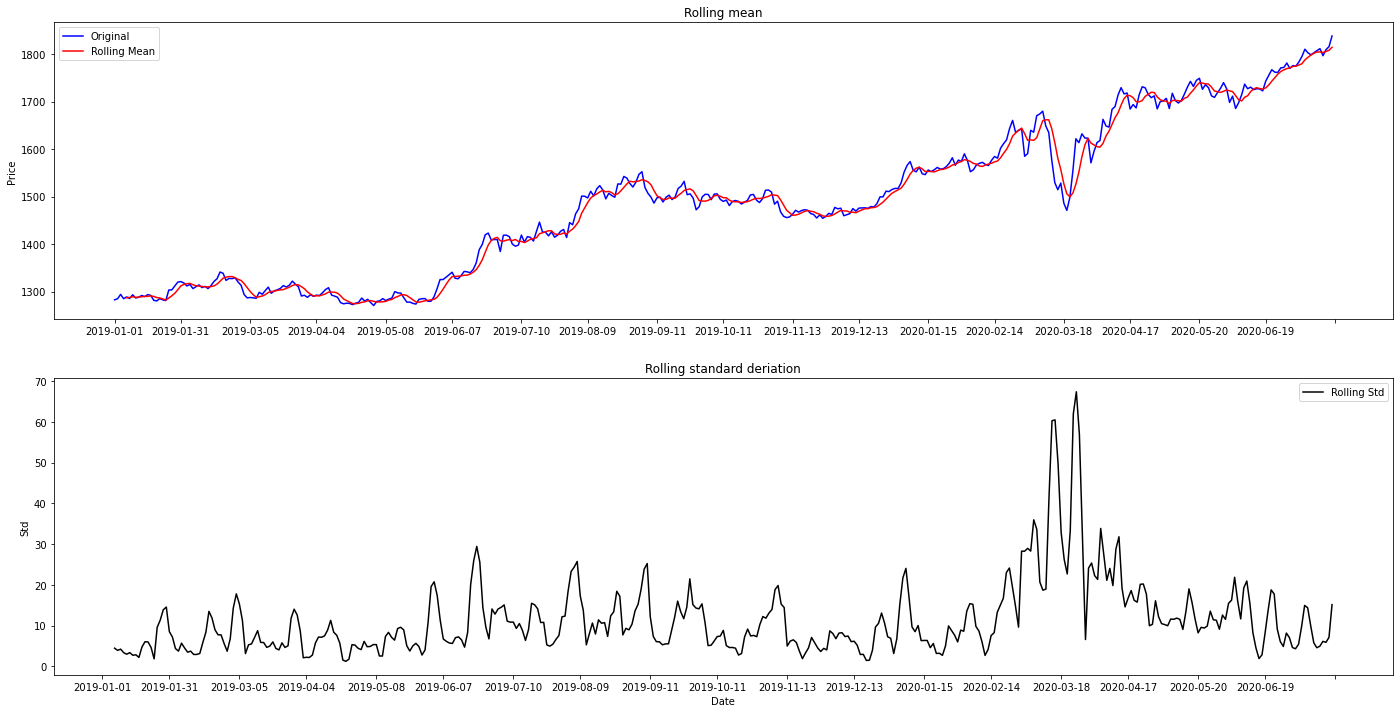

Results of ADF Test:
Test Statistic                   0.428900
p-value                          0.982544
Lags Used                       17.000000
Number of Observations Used    387.000000
Critical Value (1%)             -3.447361
Critical Value (5%)             -2.869037
Critical Value (10%)            -2.570764
dtype: float64


In [36]:
stationarity_test(G_price.sort_values('Date')['Price'],G_price.sort_values('Date')['Date'])

For a Time series to be stationary, its ADF test should have:
- *p-value* to be low (according to the null hypothesis)
- The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics

From the above ADF test result, we see that p-value is 0.98, which is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is not stationary.

Another interesing finding from the test is:

- There is large standard error starting from 2020-02, maybe due to COVID-19


## 3.5 Data Decomposition

To better deal with non-stationary data, I decide to use data decomposition.

In [37]:
# extract and sort the data
G_price_S=G_price[['Date','Price']].sort_values('Date').set_index('Date')

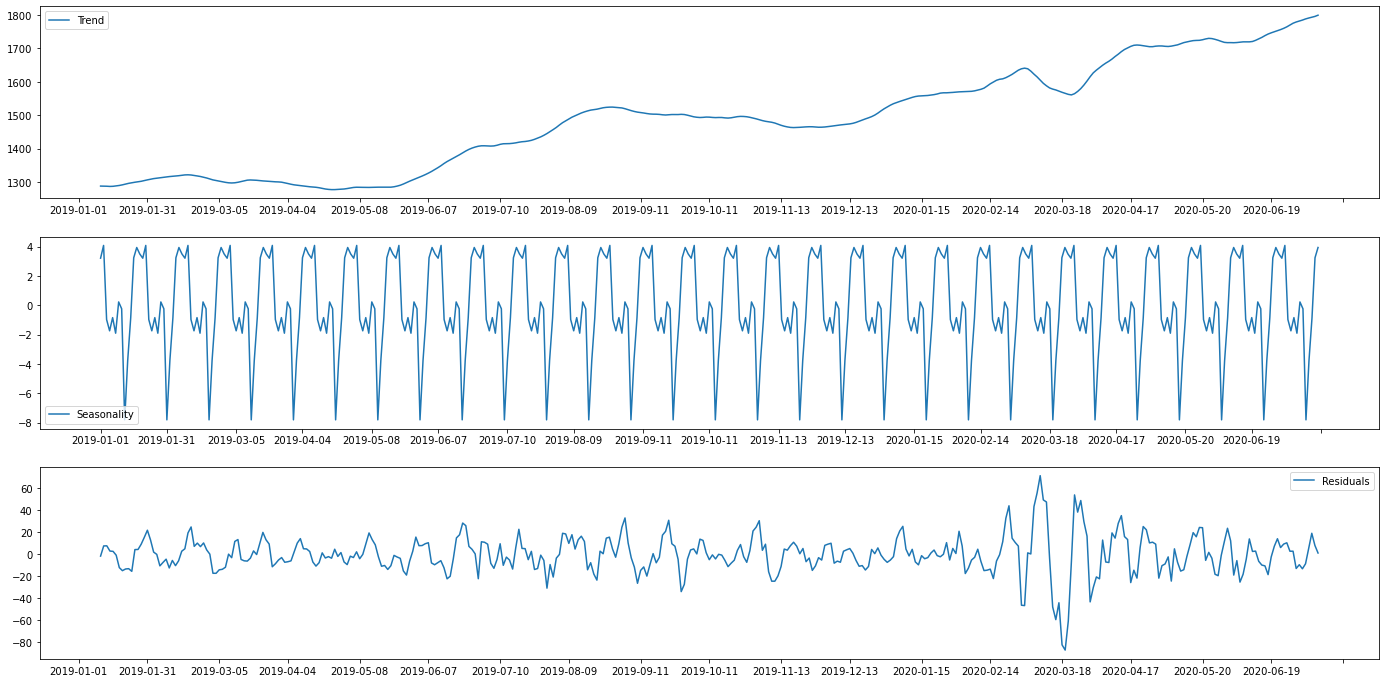

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(G_price_S, freq=14)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure()
plt.subplot(311)
plt.plot(trend, label='Trend')
ax = plt.gca()
ax.set_xticks(np.linspace(0,len(trend),19,endpoint=True,dtype='int64'))
plt.legend()
plt.subplot(312)
plt.plot(seasonal,label='Seasonality')
ax = plt.gca()
ax.set_xticks(np.linspace(0,len(seasonal),19,endpoint=True,dtype='int64'))
plt.legend()
plt.subplot(313)
plt.plot(residual, label='Residuals')
ax = plt.gca()
ax.set_xticks(np.linspace(0,len(residual),19,endpoint=True,dtype='int64'))
plt.legend()
plt.show()

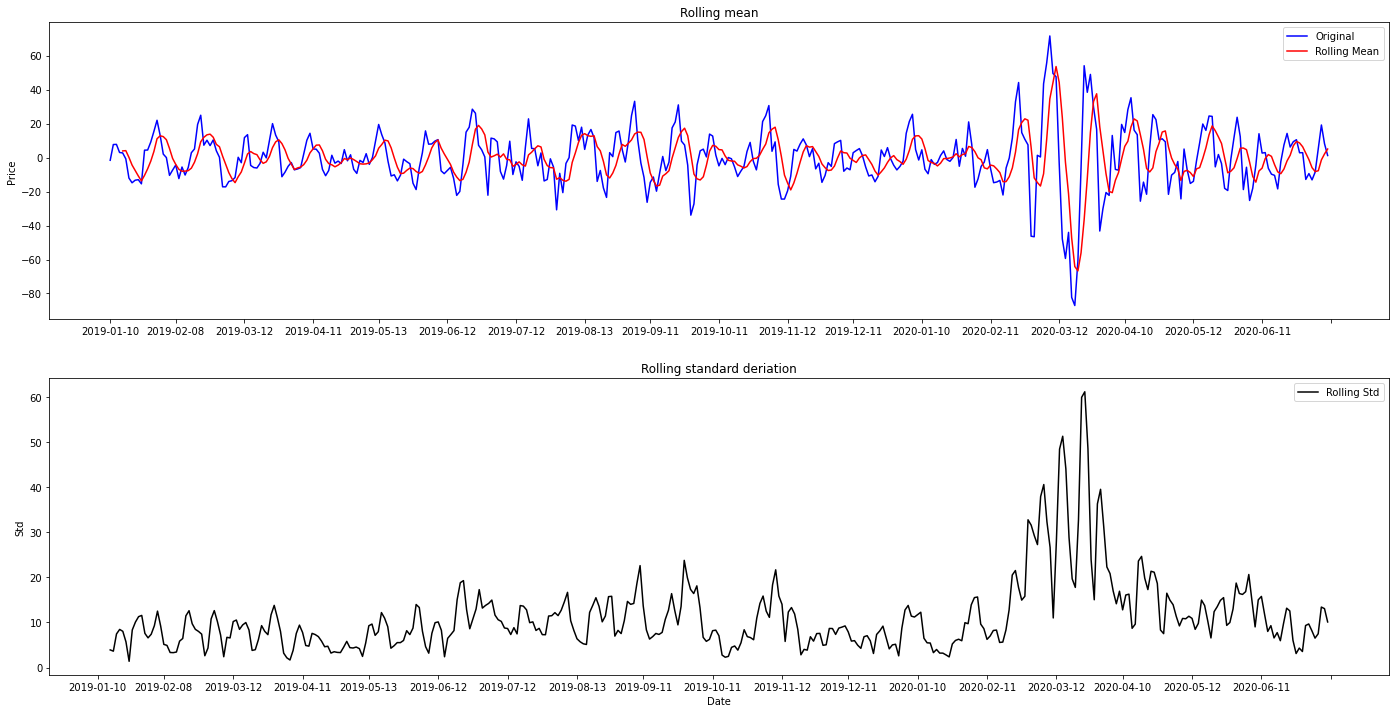

Results of ADF Test:
Test Statistic                -7.548777e+00
p-value                        3.230250e-11
Lags Used                      1.500000e+01
Number of Observations Used    3.750000e+02
Critical Value (1%)           -3.447909e+00
Critical Value (5%)           -2.869278e+00
Critical Value (10%)          -2.570892e+00
dtype: float64


In [39]:
G_price_S_decompose = residual
G_price_S_decompose.dropna(inplace=True)
stationarity_test(G_price_S_decompose,residual.dropna().index)

Important finding from the above test:
- From above plot, we can see that by doing this seasonal decomposing, the price data is broken into trend, seasonality, and residuals. From the scale of each subplot, price has very small seasonality, which makes sense, since unlike other commodities that might have seasonality, gold's mined supply is essentially constant year-round. 
- The ADF Test for the residual shows improvement in terms of *p-value* and critical values compared to Test Statistic.
- The high standard deviation starting from *2020-02* still exist in the residual time series.


## 3.6 Structural Break Detection using Chow Test

Since the high variance period always exist even after the seasonal decomposation, I suspect there is an imporant structural break and decide to perform a Chow Test.

In [40]:
# define the function for chow test
def chow_test(train, break_pt, lags):
    if break_pt >= len(train):
        raise Exception("the first section length should be smaller than the total length")
    if lags >= break_pt:
        raise Exception("lag number should be smaller that the first section length")
    # calculate the residual sum of squares (RSS) for the whole serie
    model = AutoReg(train, lags=lags)
    results = model.fit()
    coef = results.params
    predictions = []
    for t in range(lags,len(train)):
        lag = [train[i] for i in range(t-lags,t)]
        y_pred = coef[0]
        for d in range(lags):
            y_pred += coef[d+1] * lag[lags-d-1]
        y_true = train[t]
        predictions.append(y_pred)
    rss_t = mean_squared_error(train[lags:], predictions)*len(predictions) 
    # calculate the residual sum of squares (RSS) for the first section
    model = AutoReg(train[:break_pt], lags=lags)
    results = model.fit()
    coef = results.params
    predictions = []
    for t in range(lags,break_pt):
        lag = [train[i] for i in range(t-lags,t)]
        y_pred = coef[0]
        for d in range(lags):
            y_pred += coef[d+1] * lag[lags-d-1]
        y_true = train[t]
        predictions.append(y_pred)
    rss_1 = mean_squared_error(train[lags:break_pt], predictions)*len(predictions)
    # calculate the residual sum of squares (RSS) for the second section
    model = AutoReg(train[break_pt-lags:], lags=lags)
    results = model.fit()
    coef = results.params
    predictions = []
    for t in range(break_pt,len(train)):
        lag = [train[i] for i in range(t-lags,t)]
        y_pred = coef[0]
        for d in range(lags):
            y_pred += coef[d+1] * lag[lags-d-1]
        y_true = train[t]
        predictions.append(y_pred)
    rss_2 = mean_squared_error(train[break_pt:], predictions)*len(predictions)
    # n1 and n2 are respectively the length of the first section and second section
    n1 = break_pt-lags+1
    n2 = len(train) - break_pt
    # k is the degree of freedom, in this case nb of lag +1
    k = lags + 1
    f_value = (rss_t - (rss_1 + rss_2)) / k /  ((rss_1 + rss_2) / (n1 + n2 - 2*k) )
    # The survival function helps to evaluate the p-value.
    p_value = f.sf(f_value, k, n1 + n2 - 2*k)
    return f_value, p_value


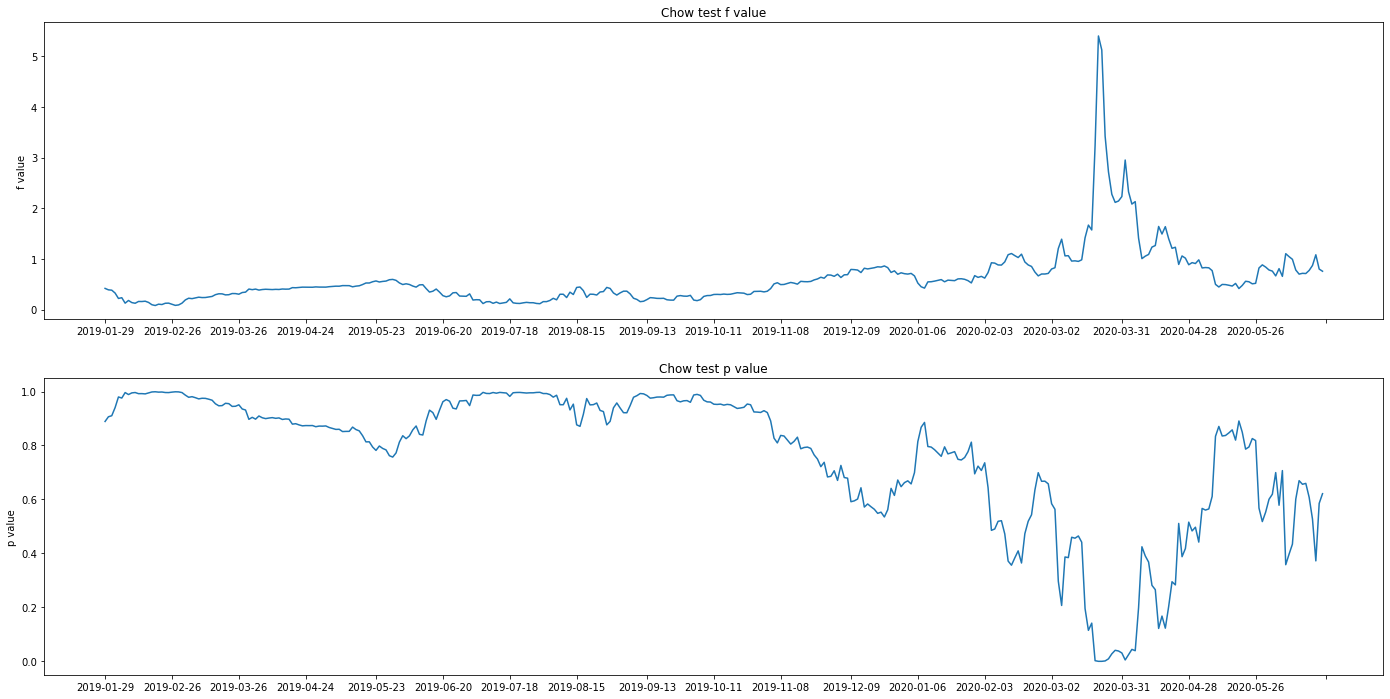

In [41]:
date=[]
f_vals=[]
p_vals=[]
# perform a Chow test for every single day (variable i) in the time series
for i in range(20,len(G_price_S)-20):
    f_val,p_val=chow_test(G_price_S['Price'].values,i,6)
    date.append(G_price_S.index[i])
    f_vals.append(f_val)
    p_vals.append(p_val)
plt.figure()
plt.subplot(211)
plt.plot(date,f_vals)
plt.ylabel('f value')
ax = plt.gca()
ax.set_xticks(np.linspace(0,len(date),19,endpoint=True,dtype='int64'))
plt.title('Chow test f value')
plt.subplot(212)
plt.plot(date,p_vals)
plt.ylabel('p value')
ax = plt.gca()
ax.set_xticks(np.linspace(0,len(date),19,endpoint=True,dtype='int64'))
plt.title('Chow test p value')
plt.show()

The null hypothesis of the Chow test asserts that before and after the breaking date, the regressor share the same parameters. The result of the Chow test shows that on 2020-03-20 the f-value has a peak with value 5.709 with a very low p-value, indicating strong evidence against the null hypothesis, so I need to reject the null hypothesis and take that structural break into consideration.

## 3.7 Incluing Structural Break in ADL Model

In [42]:
# Add the dummy variable for structural break and split the train and test data
data.loc[data['Date']<'2020-03-20','Break'] = 0
data.loc[data['Date']>='2020-03-20','Break'] = 1
rate = 0.9
train, test = data.iloc[:int(rate*len(data))], data.iloc[int(rate*len(data)):]
print("Training set : % 3d, Testing set : % 2d" %(int(rate*len(data)), len(data)-int(rate*len(data))) )

Training set :  351, Testing set :  40


I'm building the model with three additional features:
- The dummy variable representing the structural break, **lag(Break, 0)**.
- The interation of the structural break dummy variable with the 1st lagged gold spot price variable, **lag(Break, 0)*lag(G_price, 1)**.
- The interation of the structural break dummy variable with the 13th lagged gold spot price variable, **lag(Break, 0)*lag(G_price, 13)**.

In [43]:
formula = 'G_price ~ 1 + lag(Stock_ind, 15) + lag(G_price, 13) + lag(G_price, 1) + lag(Stock_ind, 14) + lag(G_trend, 2) + lag(S_price, 9) + lag(G_f_price, 13) + lag(G_f_price, 8) + lag(Break, 0) + lag(Break, 0)*lag(G_price, 13) + lag(Break, 0)*lag(G_price, 1)'
model_adl = smf.ols(formula = formula, data = train)
model_adl_fit = model_adl.fit()
aic=model_adl_fit.aic
print('Chosen ADL MODEL AIC: %.3f' % aic)
print(model_adl_fit.summary())

Chosen ADL MODEL AIC: 2712.904
                            OLS Regression Results                            
Dep. Variable:                G_price   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2992.
Date:                Tue, 21 Jul 2020   Prob (F-statistic):          2.73e-318
Time:                        14:30:41   Log-Likelihood:                -1344.5
No. Observations:                 336   AIC:                             2713.
Df Residuals:                     324   BIC:                             2759.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

Lag 16 evaluation: Test MSE: 408.394


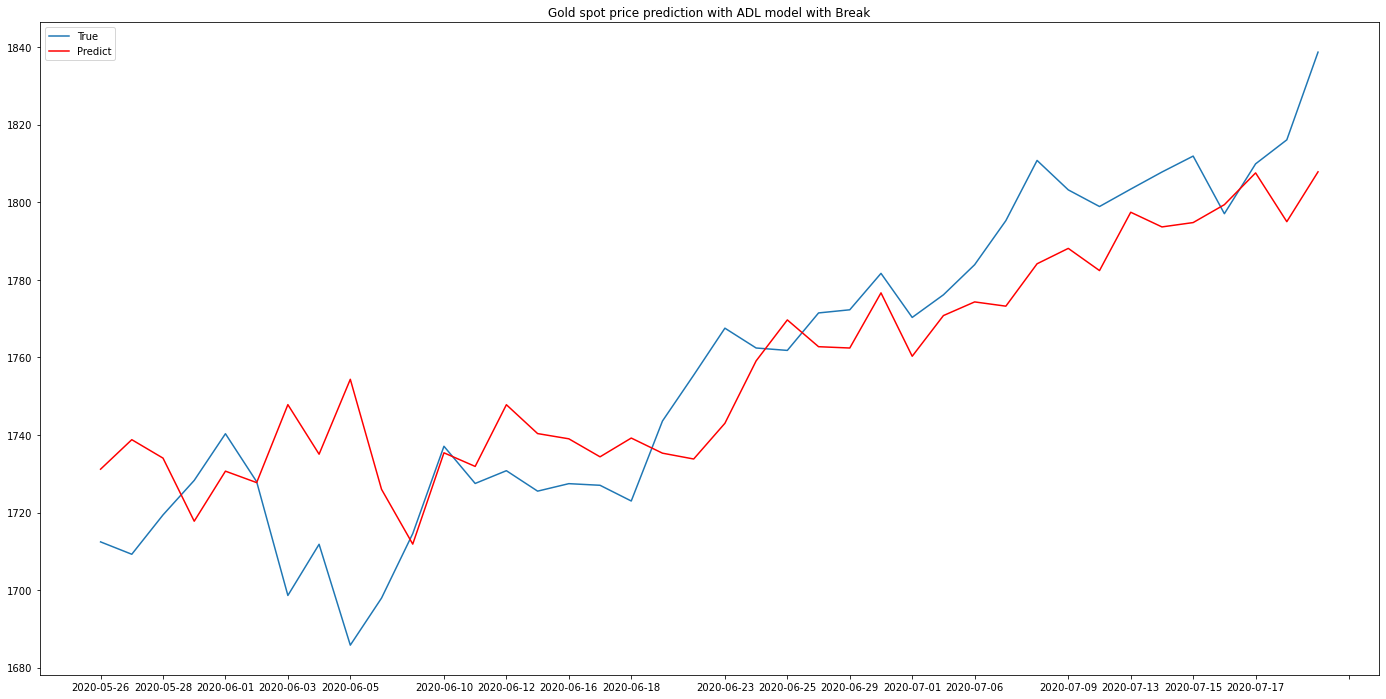

In [44]:
predictions = model_adl_prediction(model_adl_fit,train,test,max_lag_adl_model,3)
mse = mean_squared_error(test['G_price'].values, predictions)
aic = model_adl_fit.aic
print('Lag %d evaluation: Test MSE: %.3f' % (max_lag_adl_model,mse))
plt.plot(test.set_index('Date')['G_price'],label='True')
plt.plot(predictions, color='red', label='Predict')
plt.title('Gold spot price prediction with ADL model with Break')
ax=plt.gca()
ax.set_xticks(np.linspace(0,len(test),19,endpoint=True,dtype='int64'))
plt.legend()
plt.show()

Finding from the ADL model considering the structural break:
- The MSE is 408.394, and there is no clear improvement, maybe due to lack of training data.
- There is still under-estimation of the gold price starting from *2020-06-18* and the period from *2020-06-01* to *2020-06-10* is still poorly predicted.
- If I have more time, I'll dive into the modeling of the structural break, which could improve the prediction.

### Final Predicition for Gold Spot Price at *Jul 24* with ADL model considering the structural break

In [45]:
final_test = pd.DataFrame(columns=['Date','G_price','O_price','S_price','Stock_ind','G_f_price','G_trend','Break'])
final_test['Date'] = ['2020-07-22','2020-07-23','2020-07-24']
final_test['Break'] = [1,1,1]
final_train = data
max_lag_adl_model=16
jump = 3
predictions_adl_break = model_adl_prediction(model_adl_fit,final_train,final_test,max_lag_adl_model,jump)

A seasonal autoregressive integrated moving average (SARIMA) model is explored.

In [46]:
# Create the p, d, q parameter for ARAM model
import itertools
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 14) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 14)
SARIMAX: (0, 0, 1) x (0, 1, 0, 14)
SARIMAX: (0, 1, 0) x (0, 1, 1, 14)
SARIMAX: (0, 1, 0) x (1, 0, 0, 14)


In [47]:
# Split the time series data into train and test
# 90% for training and 10% for testing
rate = 0.9
X = G_price.sort_values('Date').set_index('Date')['Price']
train, test = X[:int(rate*len(X))], X[int(rate*len(X)):]
print("Training set : % 3d, Testing set : % 2d" %(int(rate*len(X)), len(X)-int(rate*len(X))) )

Training set :  364, Testing set :  41


In [48]:
# Select the best fitting model by minimizing AIC (Akaike Information Criterion) and BIC (Bayes Information Criterion)
aics = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        model = SARIMAX(train.values,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = model.fit()
        print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        aics.append(results.aic)
        SARIMAX_model.append([param, param_seasonal])
best_param=SARIMAX_model[aics.index(min(aics))][0]
best_param_seasonal=SARIMAX_model[aics.index(min(aics))][1]
best_model = SARIMAX(train.values,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(aics), best_param, best_param_seasonal))

SARIMAX(0, 0, 0)x(0, 0, 0, 14) - AIC:6325.424744718826
SARIMAX(0, 0, 0)x(0, 0, 1, 14) - AIC:5650.8845604869475
SARIMAX(0, 0, 0)x(0, 1, 0, 14) - AIC:3697.4507357628395
SARIMAX(0, 0, 0)x(0, 1, 1, 14) - AIC:3561.4331002270415
SARIMAX(0, 0, 0)x(1, 0, 0, 14) - AIC:3661.376610866446
SARIMAX(0, 0, 0)x(1, 0, 1, 14) - AIC:3639.399158255225
SARIMAX(0, 0, 0)x(1, 1, 0, 14) - AIC:3571.342224602643
SARIMAX(0, 0, 0)x(1, 1, 1, 14) - AIC:3562.7143784713026
SARIMAX(0, 0, 1)x(0, 0, 0, 14) - AIC:5817.1570846865625
SARIMAX(0, 0, 1)x(0, 0, 1, 14) - AIC:5168.608197389059
SARIMAX(0, 0, 1)x(0, 1, 0, 14) - AIC:3391.2142913889456
SARIMAX(0, 0, 1)x(0, 1, 1, 14) - AIC:3259.1103012319727
SARIMAX(0, 0, 1)x(1, 0, 0, 14) - AIC:3376.5118685849916
D:\Users\jiang\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
SARIMAX(0, 0, 1)x(1, 0

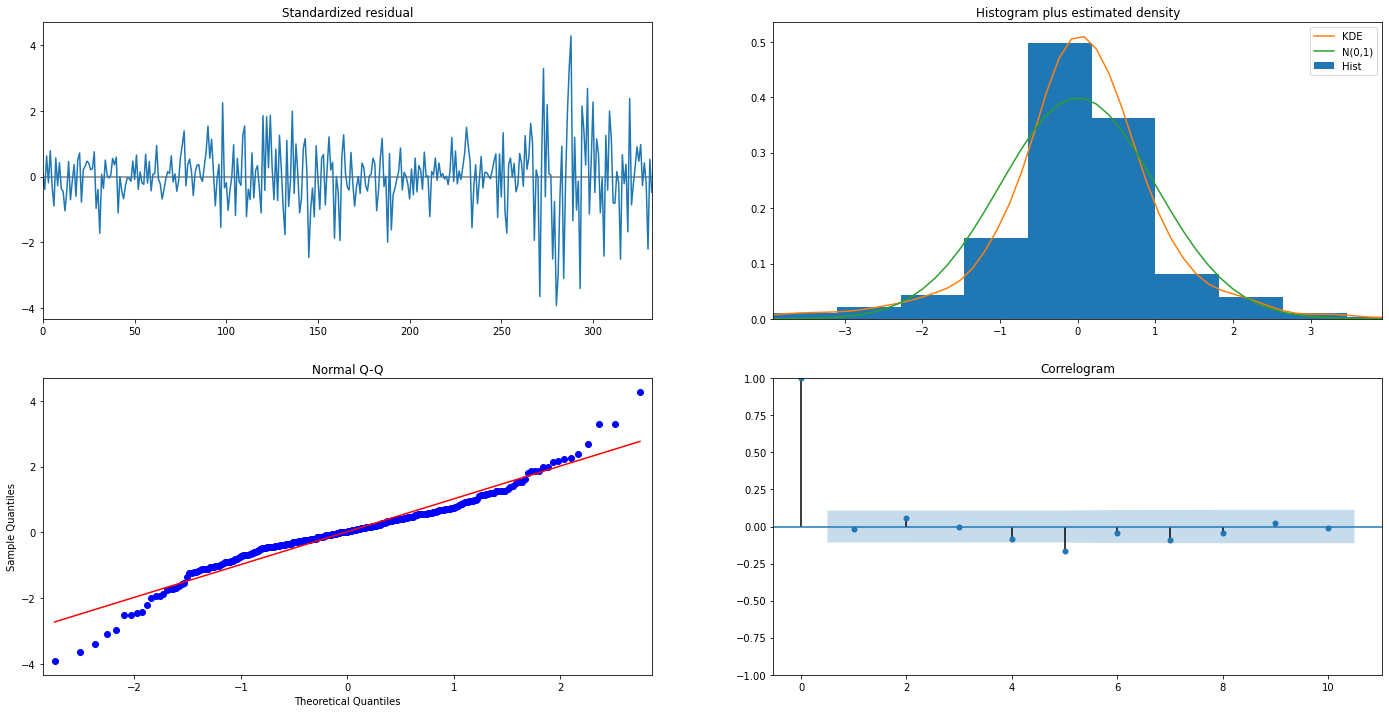

In [49]:
results = best_model.fit()
results.plot_diagnostics()
plt.show()

In [50]:
# define the function to rolling prediction function for SARIMA model
# to predict 3-day gold price (jump=3)
def model_sarrima_prediction(param,param_seasonal,train,test):
    train=list(train.values)
    predictions = []
    jump=3
    nb_steps=len(test)//jump+1
    for t in range(nb_steps):
        model_arima=SARIMAX(train, order=param, seasonal_order=param_seasonal)
        model_fit=model_arima.fit()
        y_pred = model_fit.forecast(steps=3)
        predictions.extend(y_pred)
        if len(predictions) >= len(test):
            return predictions
        y_true=test[jump*t:jump*(t+1)].values
        train.extend(y_true)
    return predictions

SARIMA Model Evaluation: Test MSE: 332.989


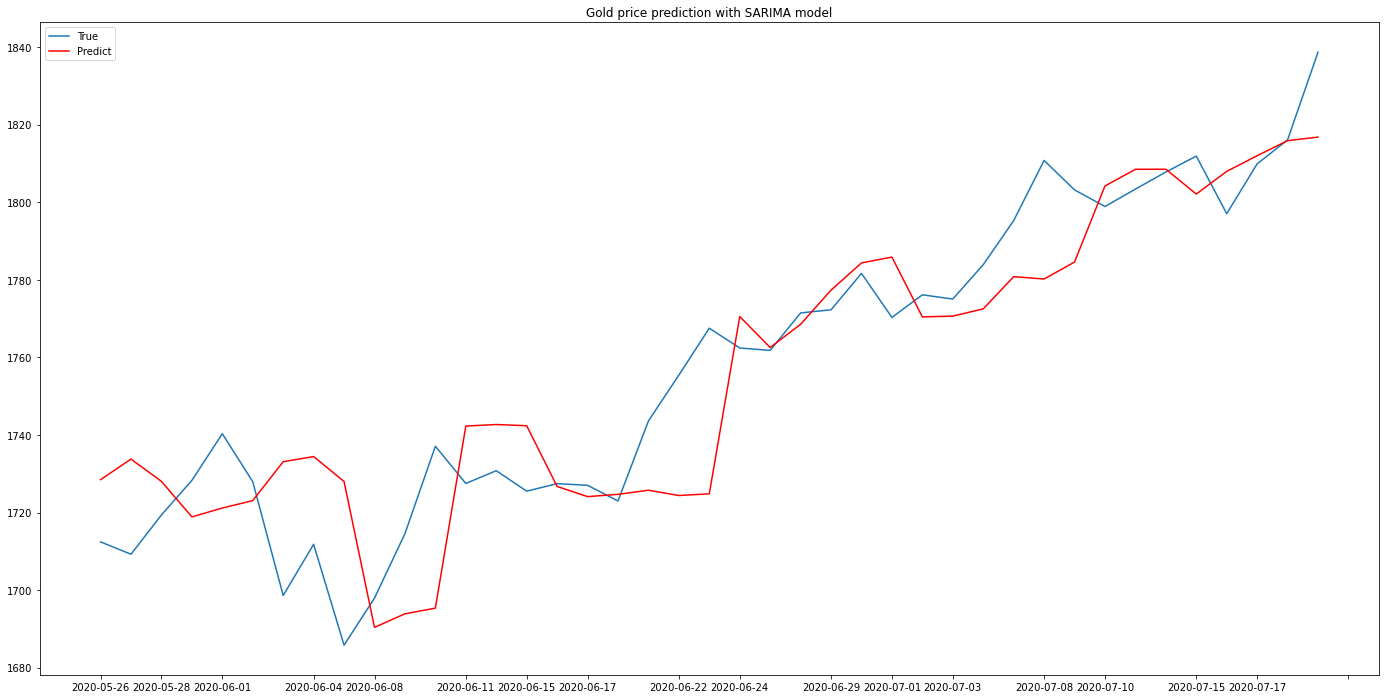

In [51]:
# predict 3-day gold price using SARIMA model
predictions = model_sarrima_prediction(param,param_seasonal,train,test)[:len(test)]
mse = mean_squared_error(test, predictions)
print('SARIMA Model Evaluation: Test MSE: %.3f' % (mse))
plt.plot(test,label='True')
plt.plot(predictions, color='red', label='Predict')
ax = plt.gca()
ax.set_xticks(np.linspace(0,len(test),18,endpoint=True,dtype='int64'))
plt.title('Gold price prediction with SARIMA model')
plt.legend()
plt.show()

Finding from the SARIMA model:
- The prediction perform well.
- The predictin from *2020-06-24* is much improved compare to previous models.
- There is still lag effect when there is an abrupt price change.

### Final Predicition for Gold Spot Price at *Jul 24* with SARIMA model

In [52]:
final_test = pd.Series(index=['2020-07-22','2020-07-23','2020-07-24'],name='G_price')
final_train = G_price.set_index('Date').sort_values('Date')['Price']
predictions_sarima = model_sarrima_prediction(param,param_seasonal,final_train,final_test)[:len(final_test)]

# 4. Final Prediction and Comparison

Let's compare the predicted gold spot price by four models

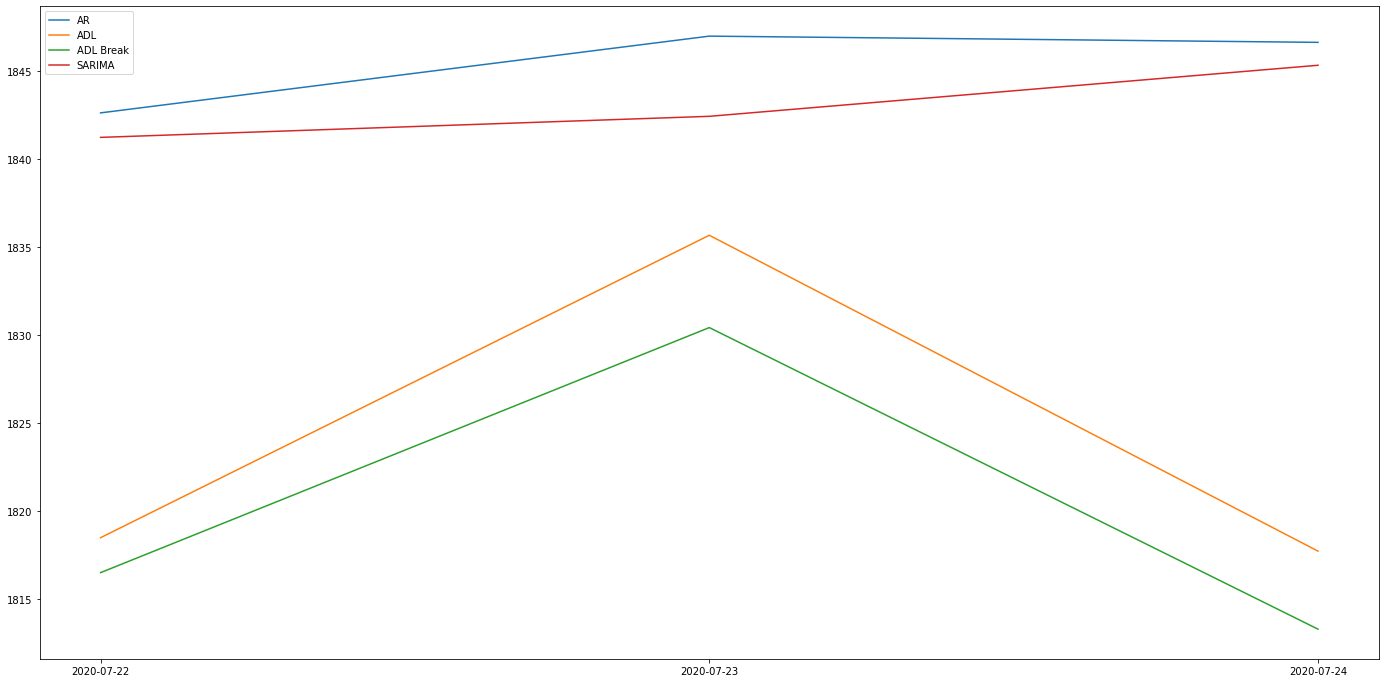

In [53]:
predictions_adl= pd.Series(index=['2020-07-22','2020-07-23','2020-07-24'],data=predictions_adl)
plt.figure()
plt.plot(predictions_ar, label='AR')
plt.plot(predictions_adl, label='ADL')
plt.plot(predictions_adl_break, label='ADL Break')
plt.plot(predictions_sarima, label='SARIMA')
plt.legend()
plt.show()

In [54]:
results={'AR':predictions_ar,'ADL':predictions_adl,'ADL Break':predictions_adl_break,'SARIMA':predictions_sarima}
df_results=pd.DataFrame(data=results,index=['2020-07-22','2020-07-23','2020-07-24'])
df_results

,AR,ADL,ADL Break,SARIMA
2020-07-22,1842.612976,1818.50442,1816.521428,1841.222146
2020-07-23,1846.968253,1835.66733,1830.428086,1842.417482
2020-07-24,1846.615017,1817.74171,1813.314325,1845.314895


It is shown that AR and SARIMA model predict the gold price to increase from *23 Jul* to *24 Jul*, while ADL and ADL Break model price to decrease from *23 Jul* to *24 Jul*.

# Future Work
- Exploring more data, eg. text message from breaking news titles.
- Using deep learning model for sequential data, eg. LSTM model.
- Use more sophiscated techniques to model the structural break effect, eg. COVID-19 pandamic.